In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


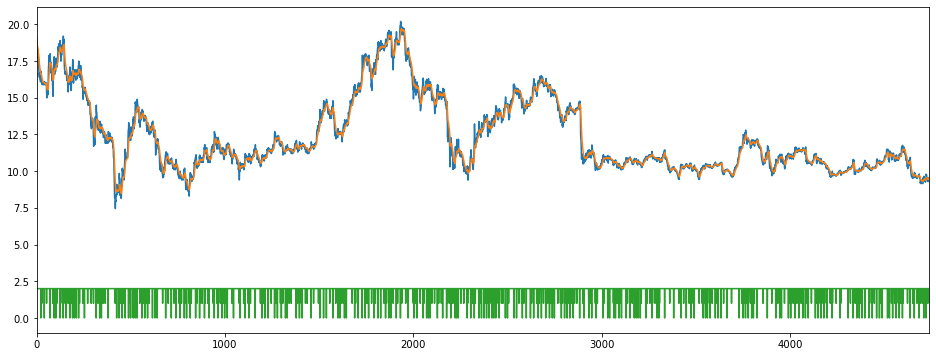

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4735, 5, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4735, 5, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4735, 5, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4735, 5, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4735, 64, 64, 1)

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.341085271317829, 1: 7.427450980392157, 2: 0.3664151673437802}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.5511 - accuracy: 0.6562 - mse: 5.6264 - weighted_accuracy: 0.4325 - weighted_mse: 6.5898WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 24ms/step - loss: 0.2425 - accuracy: 0.3646 - mse: 1.6625 - weighted_accuracy: 0.3170 - weighted_mse: 1.7469 - val_loss: 0.1856 - val_accuracy: 0.9007 - val_mse: 0.9815 - val_weighted_accuracy: 0.9007 - val_weighted_mse: 0.9815
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2055 - accuracy: 0.3738 - mse: 1.1734 - weighted_accuracy: 0.3466 - weighted_mse: 1.1719 - val_loss: 0.2010 - val_accuracy: 0.0528 - va

Epoch 27/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1947 - accuracy: 0.2138 - mse: 1.2063 - weighted_accuracy: 0.4265 - weighted_mse: 1.1734 - val_loss: 0.1974 - val_accuracy: 0.0771 - val_mse: 0.9867 - val_weighted_accuracy: 0.0771 - val_weighted_mse: 0.9867
Epoch 28/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1899 - accuracy: 0.2302 - mse: 1.2162 - weighted_accuracy: 0.4495 - weighted_mse: 1.2164 - val_loss: 0.1959 - val_accuracy: 0.0760 - val_mse: 1.0464 - val_weighted_accuracy: 0.0760 - val_weighted_mse: 1.0464
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1907 - accuracy: 0.2231 - mse: 1.2234 - weighted_accuracy: 0.4560 - weighted_mse: 1.2245 - val_loss: 0.1996 - val_accuracy: 0.0771 - val_mse: 0.9143 - val_weighted_accuracy: 0.0771 - val_weighted_mse: 0.9143
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1912 - accuracy: 0.2186 - mse: 1.2317 - weighted_accuracy: 0.4525 - weig

Epoch 56/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1757 - accuracy: 0.1616 - mse: 1.3337 - weighted_accuracy: 0.5204 - weighted_mse: 1.2964 - val_loss: 0.1976 - val_accuracy: 0.1225 - val_mse: 1.1189 - val_weighted_accuracy: 0.1225 - val_weighted_mse: 1.1189
Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1762 - accuracy: 0.1674 - mse: 1.3452 - weighted_accuracy: 0.5168 - weighted_mse: 1.3063 - val_loss: 0.2020 - val_accuracy: 0.1088 - val_mse: 1.0026 - val_weighted_accuracy: 0.1088 - val_weighted_mse: 1.0026
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1761 - accuracy: 0.1624 - mse: 1.2962 - weighted_accuracy: 0.5244 - weighted_mse: 1.2680 - val_loss: 0.1980 - val_accuracy: 0.1172 - val_mse: 1.1025 - val_weighted_accuracy: 0.1172 - val_weighted_mse: 1.1025
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1774 - accuracy: 0.1587 - mse: 1.2824 - weighted_accuracy: 0.5044 - weig

Epoch 85/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1578 - accuracy: 0.2004 - mse: 1.5080 - weighted_accuracy: 0.6088 - weighted_mse: 1.4673 - val_loss: 0.1967 - val_accuracy: 0.2080 - val_mse: 1.3316 - val_weighted_accuracy: 0.2080 - val_weighted_mse: 1.3316
Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1572 - accuracy: 0.2104 - mse: 1.4518 - weighted_accuracy: 0.5903 - weighted_mse: 1.4048 - val_loss: 0.1923 - val_accuracy: 0.2260 - val_mse: 1.3414 - val_weighted_accuracy: 0.2260 - val_weighted_mse: 1.3414
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1533 - accuracy: 0.2130 - mse: 1.5438 - weighted_accuracy: 0.6079 - weighted_mse: 1.5298 - val_loss: 0.1993 - val_accuracy: 0.1742 - val_mse: 1.3477 - val_weighted_accuracy: 0.1742 - val_weighted_mse: 1.3477
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.2138 - mse: 1.5821 - weighted_accuracy: 0.6157 - weig

Epoch 114/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1436 - accuracy: 0.2920 - mse: 1.7089 - weighted_accuracy: 0.6517 - weighted_mse: 1.7452 - val_loss: 0.1977 - val_accuracy: 0.2629 - val_mse: 1.4781 - val_weighted_accuracy: 0.2629 - val_weighted_mse: 1.4781
Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1449 - accuracy: 0.2867 - mse: 1.6975 - weighted_accuracy: 0.6627 - weighted_mse: 1.6932 - val_loss: 0.1889 - val_accuracy: 0.2999 - val_mse: 1.4742 - val_weighted_accuracy: 0.2999 - val_weighted_mse: 1.4742
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1427 - accuracy: 0.3078 - mse: 1.7127 - weighted_accuracy: 0.6649 - weighted_mse: 1.7742 - val_loss: 0.1926 - val_accuracy: 0.2925 - val_mse: 1.5189 - val_weighted_accuracy: 0.2925 - val_weighted_mse: 1.5189
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1434 - accuracy: 0.3149 - mse: 1.7606 - weighted_accuracy: 0.6713 -

Epoch 143/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1298 - accuracy: 0.4253 - mse: 2.0346 - weighted_accuracy: 0.7283 - weighted_mse: 2.2192 - val_loss: 0.1767 - val_accuracy: 0.4731 - val_mse: 1.8559 - val_weighted_accuracy: 0.4731 - val_weighted_mse: 1.8559
Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1289 - accuracy: 0.4440 - mse: 2.0344 - weighted_accuracy: 0.7407 - weighted_mse: 2.2123 - val_loss: 0.1771 - val_accuracy: 0.4720 - val_mse: 1.7367 - val_weighted_accuracy: 0.4720 - val_weighted_mse: 1.7367
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1307 - accuracy: 0.4271 - mse: 1.9747 - weighted_accuracy: 0.7234 - weighted_mse: 2.2109 - val_loss: 0.1809 - val_accuracy: 0.4245 - val_mse: 1.6974 - val_weighted_accuracy: 0.4245 - val_weighted_mse: 1.6974
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1321 - accuracy: 0.4158 - mse: 1.9522 - weighted_accuracy: 0.7045 -

Epoch 172/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1159 - accuracy: 0.5211 - mse: 2.3505 - weighted_accuracy: 0.7782 - weighted_mse: 2.8706 - val_loss: 0.1616 - val_accuracy: 0.5744 - val_mse: 1.9996 - val_weighted_accuracy: 0.5744 - val_weighted_mse: 1.9996
Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1165 - accuracy: 0.5261 - mse: 2.4026 - weighted_accuracy: 0.7672 - weighted_mse: 2.8718 - val_loss: 0.1648 - val_accuracy: 0.5692 - val_mse: 2.0681 - val_weighted_accuracy: 0.5692 - val_weighted_mse: 2.0681
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1186 - accuracy: 0.5214 - mse: 2.3877 - weighted_accuracy: 0.7691 - weighted_mse: 2.8120 - val_loss: 0.1667 - val_accuracy: 0.5459 - val_mse: 2.0019 - val_weighted_accuracy: 0.5459 - val_weighted_mse: 2.0019
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1162 - accuracy: 0.5385 - mse: 2.3629 - weighted_accuracy: 0.7884 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14656402170658112
Test accuracy: 0.6652587056159973


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.2134163  -0.41232204 -0.45750862]
 [ 0.45116302 -3.848245   -1.1303636 ]
 [ 0.0492783  -2.6261766  -0.76159036]
 ...
 [-1.2058238  -1.1077588  -0.18997526]
 [-1.0454154  -1.7480459  -0.17620131]
 [-0.50334626 -1.3946567  -0.5054966 ]]


Counter({1: 86, 0: 209, 2: 652})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 7
actual buys but predicted sell: 5
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 22
actual sells but predicted hold: 20
actual holds but predicted buy: 78
actual holds but predicted sell: 182
actual predicted holds: 601
Percentage buys correct: 16.27906976744186%
Percentage sells correct: 51.16279069767442%
Percentage holds correct: 69.80255516840883%
actual buys: 43
actual sells: 43
actual holds: 861


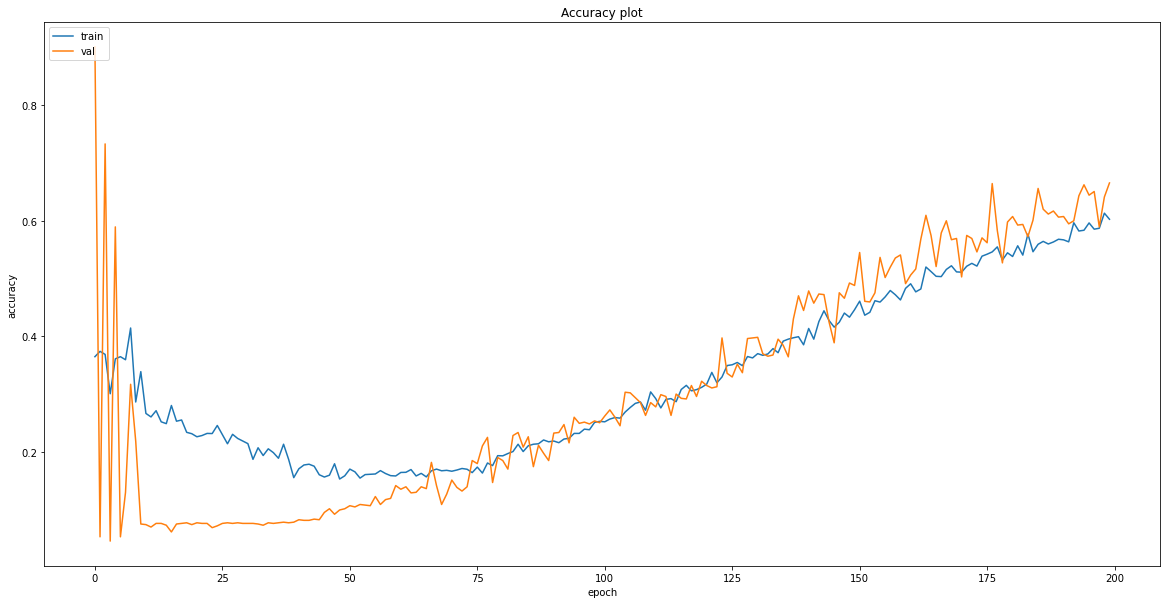

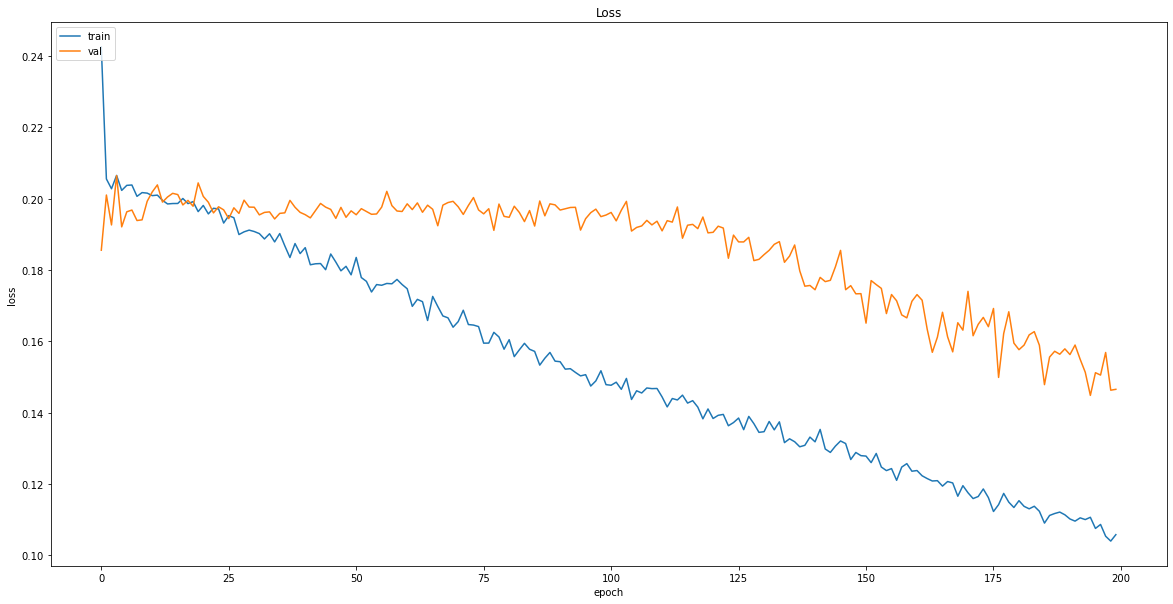

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_5.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [28]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-02-04         9.63  9.634372 -54.545402  4627100.0     2.0
2019-02-05         9.66  9.638315 -45.454598  5084100.0     2.0
2019-02-07         9.66  9.641651 -45.454598  5084100.0     2.0
2019-02-08         9.66  9.644474 -45.454598  5084100.0     2.0
2019-02-11         9.76  9.662247 -15.151533  6464788.0     2.0


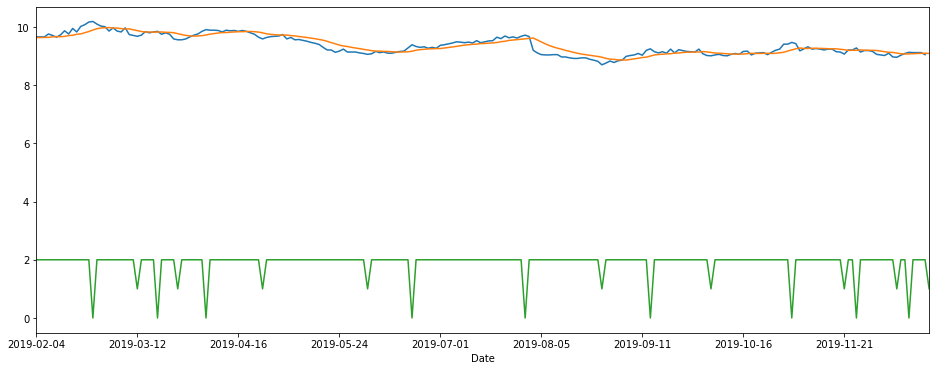

In [29]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [31]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [33]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [34]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [35]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 9ms/step - loss: 0.1334 - accuracy: 0.7018 - mean_squared_error: 2.2852 - weighted_accuracy: 0.7018 - weighted_mean_squared_error: 2.2852
Test loss: 0.13341444730758667
Test accuracy: 0.7018348574638367


In [36]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 48, 2: 155, 1: 15})

In [37]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [38]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            0   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            2   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            0   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

In [39]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

In [40]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

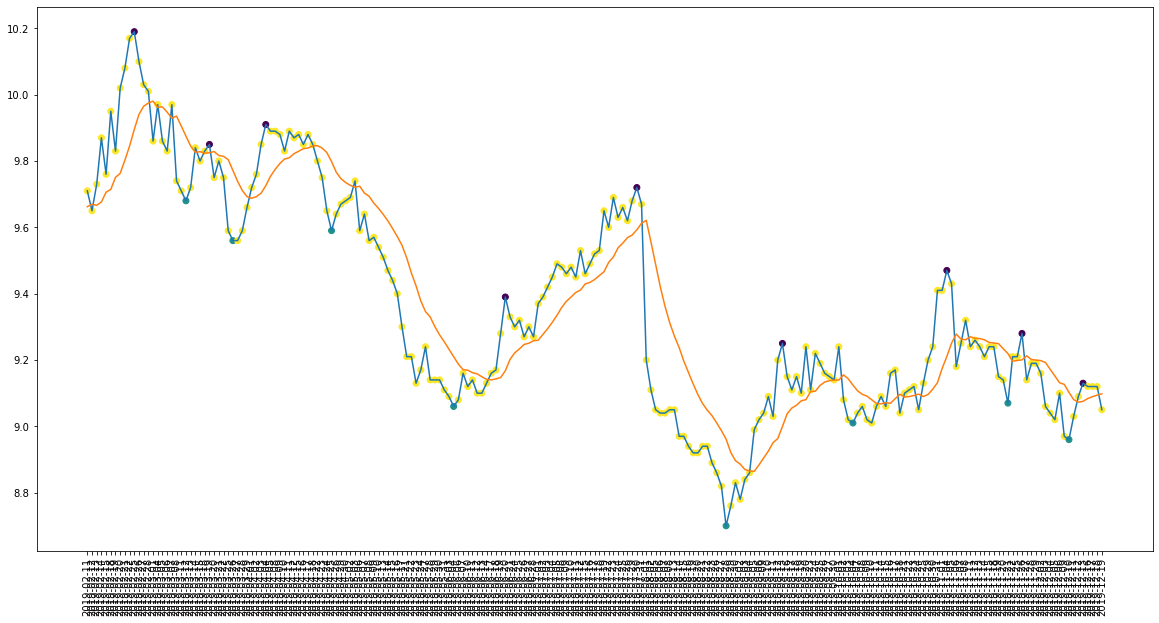

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [42]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 13
actual holds but predicted sell: 42
actual predicted holds: 145
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 72.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [43]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 50.0%
Percentage holds correct: 79.22077922077922%


In [44]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.970000267028807
Shares owned at the moment: 1000
Cash capital at the moment: $2.5822322368640016


Stop Loss Activated!

Share price: $9.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9655.96253657341


Share price: $9.75
Shares owned at the moment: 987
Cash capital at the moment: $6.248599073409423


Stop Loss Activated!

Share price: $9.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9327.434914406058


Share price: $9.130000114440918
Shares owned at the moment: 1018
Cash capital at the moment: $7.535362584825634


Price increase from previously bought: 5.405638301585958%
Share price: $9.649999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9804.219800316569


Share price: $9.109999656677246
Shares owned at the moment: 1073
Cash capital at the moment: $2.308837214943196


Stop Loss Activated!

Share price: $8.859999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9482.944824

In [45]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [46]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-02-06         8.59  8.669432 -78.124958 -1004100.0     0.0
2020-02-07         8.74  8.680288 -53.968268  1419800.0     2.0
2020-02-10         8.58  8.664859 -78.333328 -1778600.0     2.0
2020-02-11         8.51  8.641035 -89.830440 -3476200.0     2.0
2020-02-12         8.53  8.623953 -86.440694 -2356000.0     2.0


In [47]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [48]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [49]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [51]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [52]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [53]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1434 - accuracy: 0.6744 - mean_squared_error: 2.3877 - weighted_accuracy: 0.6744 - weighted_mean_squared_error: 2.3877
Test loss: 0.14337728917598724
Test accuracy: 0.6744186282157898


In [54]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 152, 0: 35, 1: 28})

In [55]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [56]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            0   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            2   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            0   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            2   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

In [57]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

In [58]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

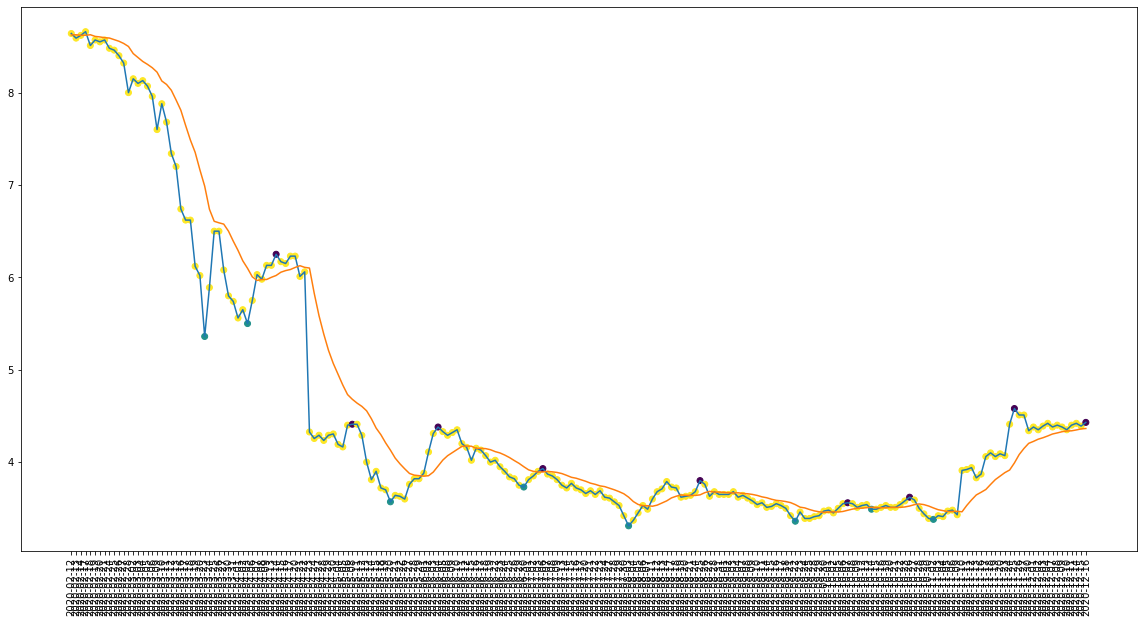

In [59]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [60]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 26
actual holds but predicted sell: 32
actual predicted holds: 140
Percentage buys correct: 25.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 70.70707070707071%
actual buys: 8
actual sells: 9
actual holds: 198


In [61]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 55.88235294117647%
Percentage holds correct: 84.21052631578948%


In [62]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.569999694824219
Shares owned at the moment: 1163
Cash capital at the moment: $5.681353395460974


Stop Loss Activated!

Share price: $8.319999694824219
Shares owned at the moment: 0
Cash capital at the moment: $9655.231559452055


Share price: $8.100000381469728
Shares owned at the moment: 1188
Cash capital at the moment: $5.968405019755664


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9009.93909203481


Share price: $7.679999828338622
Shares owned at the moment: 1169
Cash capital at the moment: $7.3300132588101405


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8564.193926143524


Share price: $7.199999809265138
Shares owned at the moment: 1186
Cash capital at the moment: $1.511352977151546


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $7973.168572269792


Share price

In [63]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [64]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


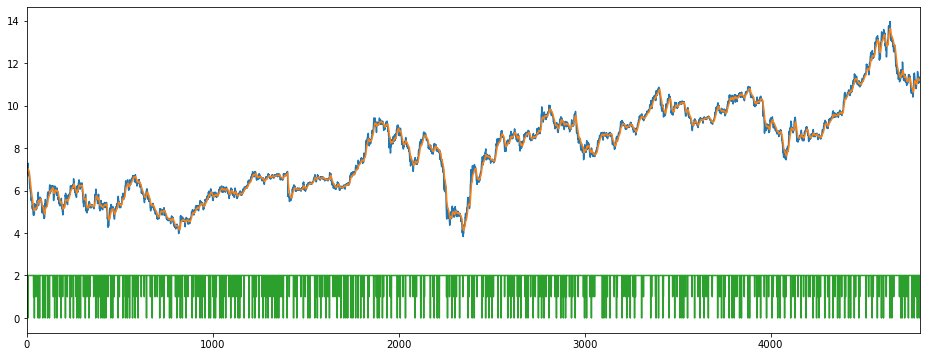

In [65]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [66]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [67]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [68]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [69]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [71]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4799, 64, 64, 1)

In [72]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [73]:
X = X/255

In [74]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [75]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [76]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [78]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2297551789077215, 1: 7.94824016563147, 2: 0.36551461487194137}
Epoch 1/200
30/30 [==============================] - 9s 292ms/step - loss: 0.2425 - accuracy: 0.3720 - mse: 1.6345 - weighted_accuracy: 0.3437 - weighted_mse: 1.7514 - val_loss: 0.2042 - val_accuracy: 0.0417 - val_mse: 0.9918 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.9918
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2058 - accuracy: 0.3472 - mse: 1.1886 - weighted_accuracy: 0.3279 - weighted_mse: 1.2019 - val_loss: 0.2050 - val_accuracy: 0.1542 - val_mse: 0.8413 - val_weighted_accuracy: 0.1542 - val_weighted_mse: 0.8413
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2048 - accuracy: 0.3321 - mse: 1.1512 - weighted_accuracy: 0.3500 - weighted_mse: 1.1645 - val_loss: 0.2094 - val_accuracy: 0.1833 - val_mse: 0.7692 - val_weighted_accuracy: 0.1833 - val_weighted_mse: 0.7692
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.20

30/30 [==============================] - 0s 10ms/step - loss: 0.1835 - accuracy: 0.3178 - mse: 1.2812 - weighted_accuracy: 0.5019 - weighted_mse: 1.2665 - val_loss: 0.1942 - val_accuracy: 0.1094 - val_mse: 1.0068 - val_weighted_accuracy: 0.1094 - val_weighted_mse: 1.0068
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1846 - accuracy: 0.3032 - mse: 1.2724 - weighted_accuracy: 0.4908 - weighted_mse: 1.2370 - val_loss: 0.1960 - val_accuracy: 0.0990 - val_mse: 1.0348 - val_weighted_accuracy: 0.0990 - val_weighted_mse: 1.0348
Epoch 30/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1847 - accuracy: 0.2871 - mse: 1.2988 - weighted_accuracy: 0.4693 - weighted_mse: 1.2808 - val_loss: 0.1954 - val_accuracy: 0.1490 - val_mse: 0.9589 - val_weighted_accuracy: 0.1490 - val_weighted_mse: 0.9589
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1822 - accuracy: 0.2714 - mse: 1.3178 - weighted_accuracy: 0.4964 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1687 - accuracy: 0.2206 - mse: 1.4808 - weighted_accuracy: 0.5403 - weighted_mse: 1.4154 - val_loss: 0.2037 - val_accuracy: 0.1063 - val_mse: 1.1718 - val_weighted_accuracy: 0.1063 - val_weighted_mse: 1.1718
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1675 - accuracy: 0.2193 - mse: 1.4583 - weighted_accuracy: 0.5721 - weighted_mse: 1.4136 - val_loss: 0.2164 - val_accuracy: 0.0823 - val_mse: 1.1872 - val_weighted_accuracy: 0.0823 - val_weighted_mse: 1.1872
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1654 - accuracy: 0.1985 - mse: 1.4946 - weighted_accuracy: 0.5655 - weighted_mse: 1.4239 - val_loss: 0.2088 - val_accuracy: 0.1083 - val_mse: 1.1247 - val_weighted_accuracy: 0.1083 - val_weighted_mse: 1.1247
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1651 - accuracy: 0.2245 - mse: 1.4760 - weighted_accuracy: 0.5850 - 

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1494 - accuracy: 0.2696 - mse: 1.6268 - weighted_accuracy: 0.6341 - weighted_mse: 1.6191 - val_loss: 0.2005 - val_accuracy: 0.2042 - val_mse: 1.3774 - val_weighted_accuracy: 0.2042 - val_weighted_mse: 1.3774
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1516 - accuracy: 0.2553 - mse: 1.5810 - weighted_accuracy: 0.6216 - weighted_mse: 1.5292 - val_loss: 0.1912 - val_accuracy: 0.2323 - val_mse: 1.2984 - val_weighted_accuracy: 0.2323 - val_weighted_mse: 1.2984
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1484 - accuracy: 0.2545 - mse: 1.6139 - weighted_accuracy: 0.6318 - weighted_mse: 1.6133 - val_loss: 0.2027 - val_accuracy: 0.1917 - val_mse: 1.4256 - val_weighted_accuracy: 0.1917 - val_weighted_mse: 1.4256
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1467 - accuracy: 0.2878 - mse: 1.6767 - weighted_accuracy: 0.6478 - 

30/30 [==============================] - 0s 10ms/step - loss: 0.1369 - accuracy: 0.3793 - mse: 1.7190 - weighted_accuracy: 0.6756 - weighted_mse: 1.7612 - val_loss: 0.1960 - val_accuracy: 0.2927 - val_mse: 1.6430 - val_weighted_accuracy: 0.2927 - val_weighted_mse: 1.6430
Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1349 - accuracy: 0.3717 - mse: 1.8445 - weighted_accuracy: 0.6858 - weighted_mse: 1.8976 - val_loss: 0.1903 - val_accuracy: 0.3146 - val_mse: 1.5834 - val_weighted_accuracy: 0.3146 - val_weighted_mse: 1.5834
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1303 - accuracy: 0.3816 - mse: 1.8901 - weighted_accuracy: 0.7012 - weighted_mse: 1.9696 - val_loss: 0.1815 - val_accuracy: 0.3729 - val_mse: 1.7684 - val_weighted_accuracy: 0.3729 - val_weighted_mse: 1.7684
Epoch 117/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1331 - accuracy: 0.4090 - mse: 1.8653 - weighted_accuracy: 0.7017 - weighted_m

30/30 [==============================] - 0s 10ms/step - loss: 0.1157 - accuracy: 0.4764 - mse: 2.0408 - weighted_accuracy: 0.7429 - weighted_mse: 2.3158 - val_loss: 0.1704 - val_accuracy: 0.4760 - val_mse: 1.8251 - val_weighted_accuracy: 0.4760 - val_weighted_mse: 1.8251
Epoch 143/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1156 - accuracy: 0.4996 - mse: 2.1207 - weighted_accuracy: 0.7442 - weighted_mse: 2.4518 - val_loss: 0.1758 - val_accuracy: 0.4385 - val_mse: 1.7364 - val_weighted_accuracy: 0.4385 - val_weighted_mse: 1.7364
Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1193 - accuracy: 0.4973 - mse: 2.0011 - weighted_accuracy: 0.7364 - weighted_mse: 2.2502 - val_loss: 0.1672 - val_accuracy: 0.4948 - val_mse: 1.8646 - val_weighted_accuracy: 0.4948 - val_weighted_mse: 1.8646
Epoch 145/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1150 - accuracy: 0.4980 - mse: 2.2024 - weighted_accuracy: 0.7472 - weighted_m

Epoch 171/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1008 - accuracy: 0.5926 - mse: 2.3651 - weighted_accuracy: 0.7772 - weighted_mse: 2.7437 - val_loss: 0.1613 - val_accuracy: 0.5615 - val_mse: 2.0020 - val_weighted_accuracy: 0.5615 - val_weighted_mse: 2.0020
Epoch 172/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0999 - accuracy: 0.6035 - mse: 2.3253 - weighted_accuracy: 0.7859 - weighted_mse: 2.7430 - val_loss: 0.1543 - val_accuracy: 0.5865 - val_mse: 2.0565 - val_weighted_accuracy: 0.5865 - val_weighted_mse: 2.0565
Epoch 173/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0974 - accuracy: 0.6265 - mse: 2.4014 - weighted_accuracy: 0.8049 - weighted_mse: 2.8536 - val_loss: 0.1587 - val_accuracy: 0.5740 - val_mse: 2.1598 - val_weighted_accuracy: 0.5740 - val_weighted_mse: 2.1598
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1022 - accuracy: 0.6226 - mse: 2.4791 - weighted_accuracy: 0.773

Epoch 199/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0893 - accuracy: 0.6997 - mse: 2.6845 - weighted_accuracy: 0.8207 - weighted_mse: 3.3076 - val_loss: 0.1376 - val_accuracy: 0.6719 - val_mse: 2.2499 - val_weighted_accuracy: 0.6719 - val_weighted_mse: 2.2499
Epoch 200/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0862 - accuracy: 0.7041 - mse: 2.7384 - weighted_accuracy: 0.8261 - weighted_mse: 3.4993 - val_loss: 0.1394 - val_accuracy: 0.6573 - val_mse: 2.2479 - val_weighted_accuracy: 0.6573 - val_weighted_mse: 2.2479


In [79]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1394195258617401
Test accuracy: 0.6572916507720947


In [80]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.1638236e+00 -1.1187180e+00  1.7988309e-03]
 [-1.6134549e+00 -4.6658337e-01 -3.9186928e-01]
 [-4.1427532e-01 -1.6673310e+00 -5.6941634e-01]
 ...
 [-1.2512087e+00 -1.5452166e+00  1.1793018e-01]
 [-2.6676898e+00 -7.0859116e-01 -2.8039703e-01]
 [-2.1001968e+00 -5.8940470e-01 -2.9739898e-01]]


Counter({2: 654, 0: 161, 1: 145})

In [81]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 876, 1: 40, 0: 44})

In [82]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 960
actual predicted buys: 15
actual buys but predicted sell: 2
actual buys but predicted hold: 23
actual sells but predicted buy: 1
actual predicted sells: 14
actual sells but predicted hold: 29
actual holds but predicted buy: 129
actual holds but predicted sell: 145
actual predicted holds: 602
Percentage buys correct: 37.5%
Percentage sells correct: 31.818181818181817%
Percentage holds correct: 68.72146118721462%
actual buys: 40
actual sells: 44
actual holds: 876


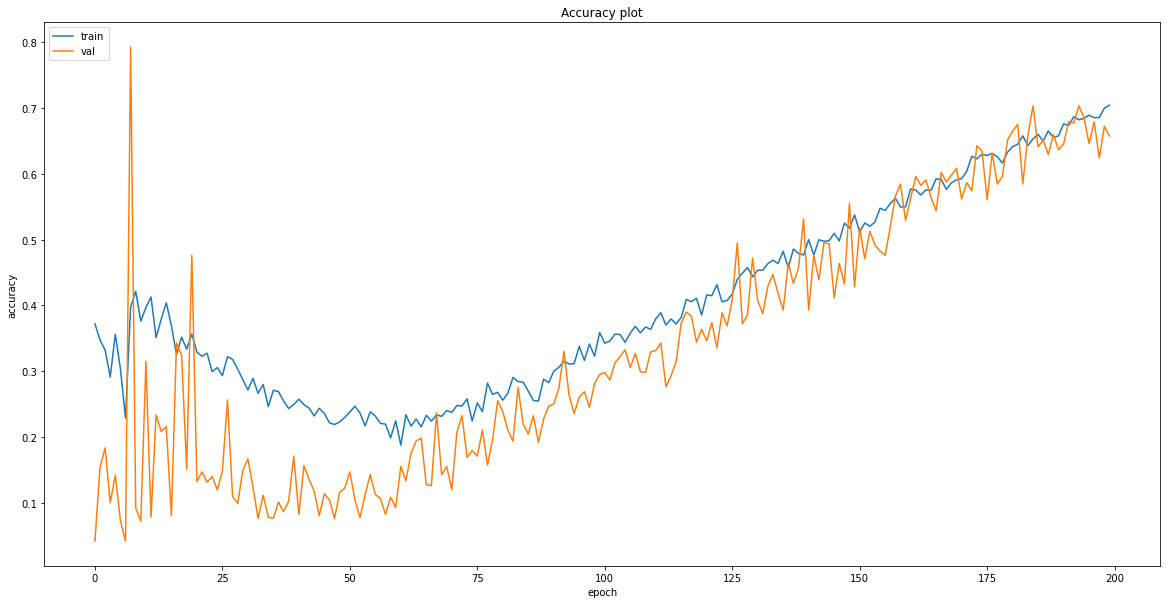

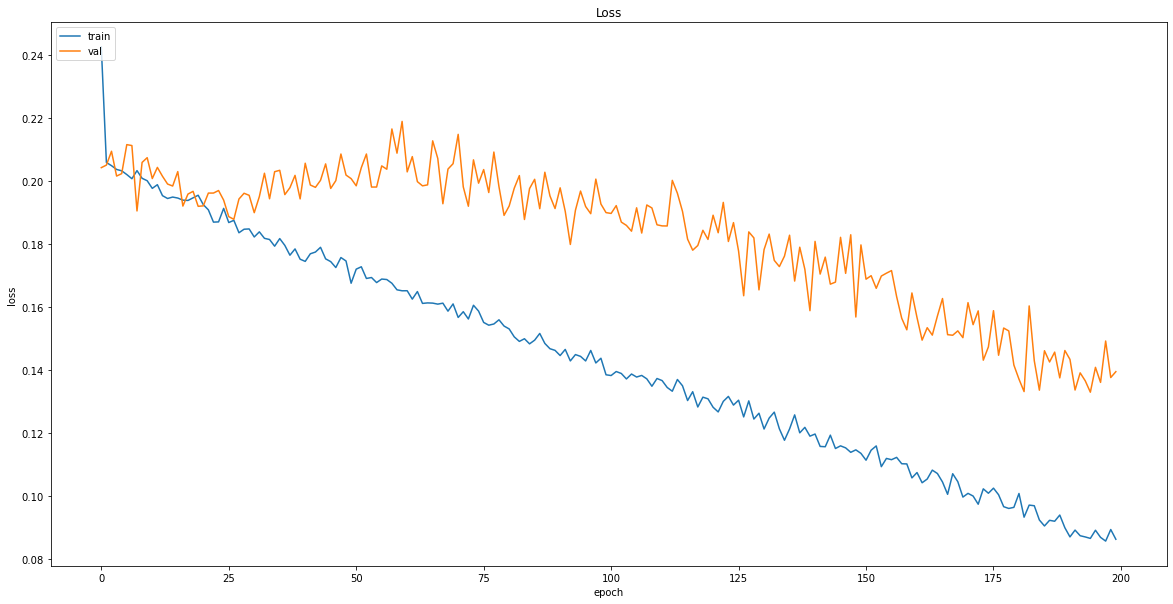

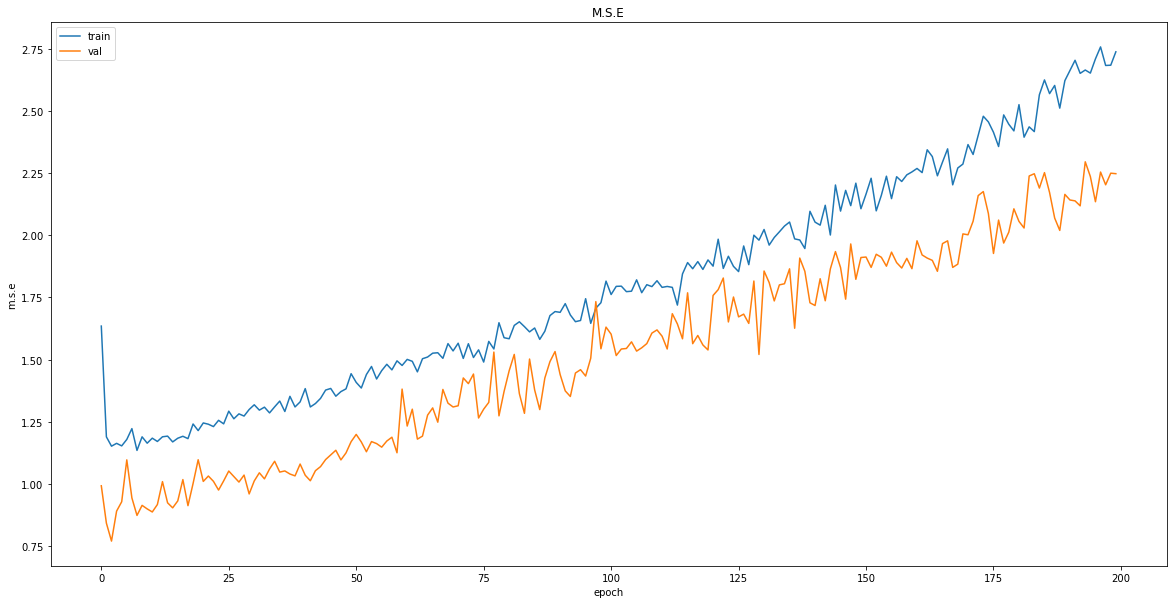

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

#### Non-Recession

In [85]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-02-04        11.45  11.473251 -73.214328  19702751.0     1.0
2019-02-05        11.38  11.458905 -85.714286  17849651.0     2.0
2019-02-07        11.38  11.446765 -85.714286  17849651.0     2.0
2019-02-08        11.49  11.453417 -66.071471  20418651.0     2.0
2019-02-11        11.48  11.457507 -67.857228  17615658.0     2.0


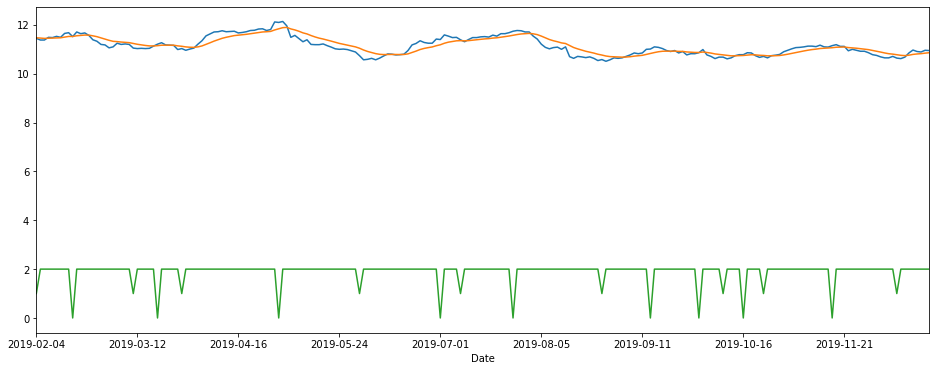

In [86]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [87]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [89]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [90]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [91]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1419 - accuracy: 0.6560 - mean_squared_error: 2.2737 - weighted_accuracy: 0.6560 - weighted_mean_squared_error: 2.2737
Test loss: 0.14190804958343506
Test accuracy: 0.6559633016586304


In [92]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 151, 0: 35, 1: 32})

In [93]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [94]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            0       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            0       2

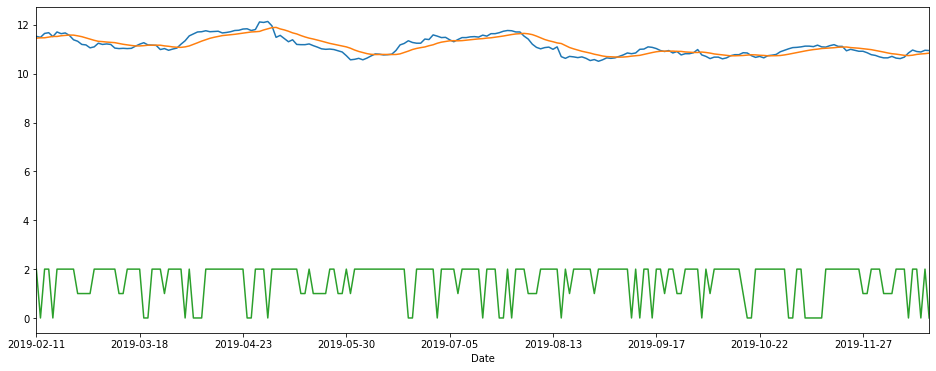

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

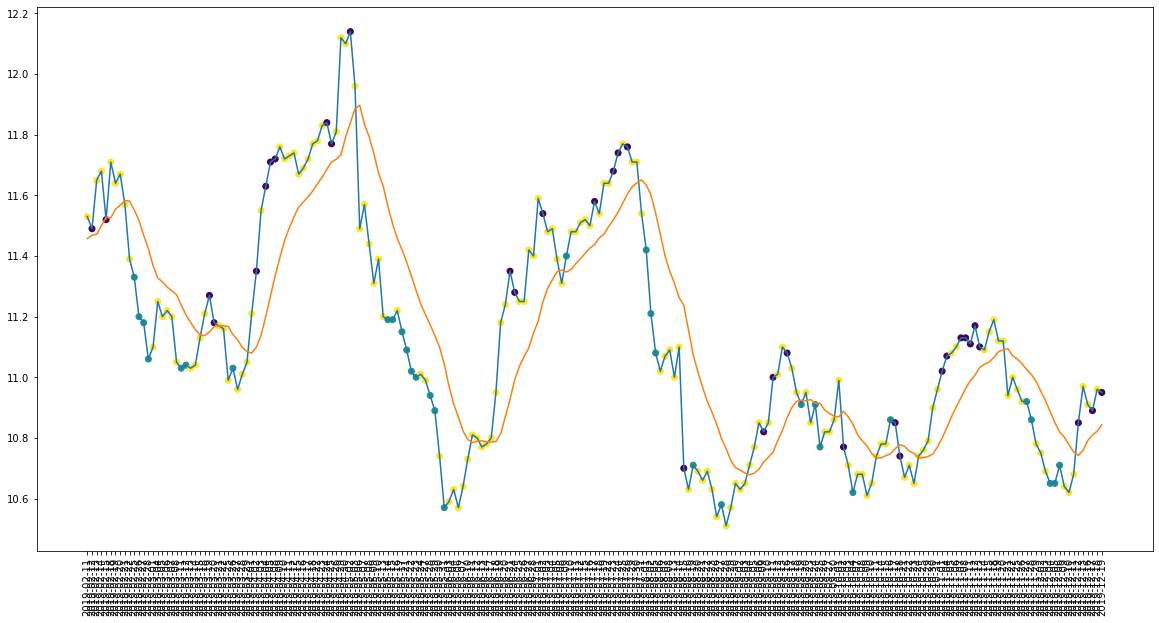

In [96]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

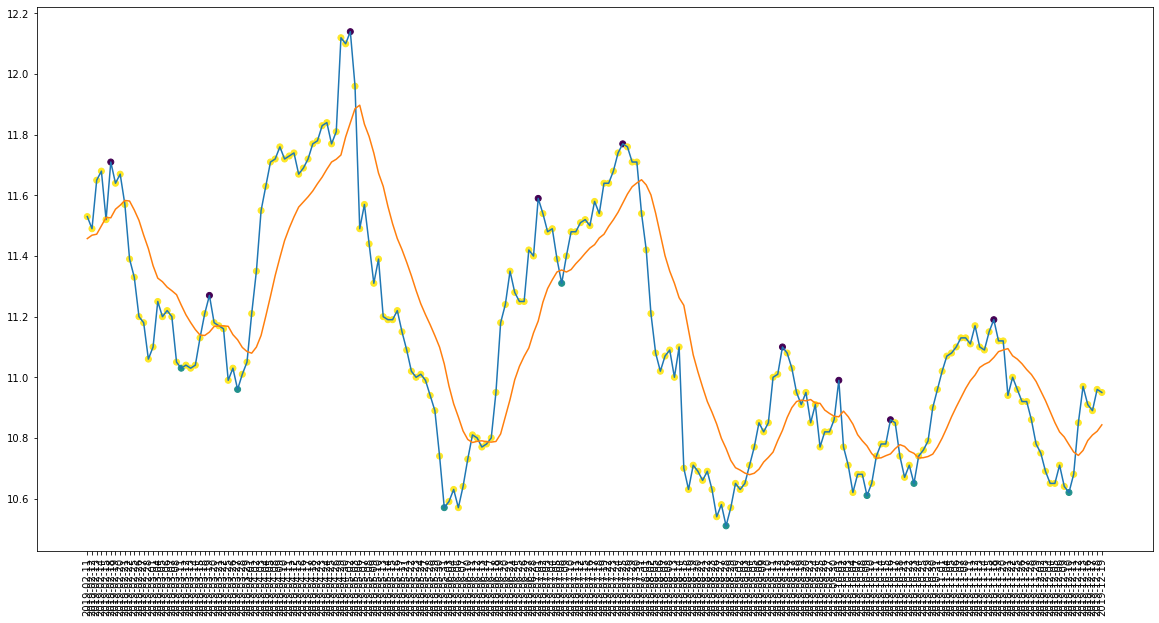

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [98]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 29
actual holds but predicted sell: 33
actual predicted holds: 139
Percentage buys correct: 25.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 69.1542288557214%
actual buys: 8
actual sells: 9
actual holds: 201


In [99]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 56.25%
Percentage sells correct: 48.57142857142857%
Percentage holds correct: 85.33333333333333%


In [100]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.329999923706055
Shares owned at the moment: 880
Cash capital at the moment: $2.1814673233020585


Stop Loss Activated!

Share price: $10.989999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9646.78546646118


Share price: $11.029999732971193
Shares owned at the moment: 872
Cash capital at the moment: $2.1757599506345286


Price increase from previously bought: 5.150549461287213%
Share price: $11.630000114440918
Shares owned at the moment: 0
Cash capital at the moment: $10115.647119468686


Share price: $11.1899995803833
Shares owned at the moment: 901
Cash capital at the moment: $5.731476083035886


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9655.860235427614


Share price: $10.56999969482422
Shares owned at the moment: 911
Cash capital at the moment: $0.11002170728897909


Price increase from previously bought: 7.0848988287468995%
Share price: $11.350000381469727
Shares owned 

In [101]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


#### Recession

In [102]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df = df.iloc[10:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-06        11.00  10.944147 -43.396162  18634735.0     0.0
2020-02-07        11.07  10.963509 -30.188666  22671000.0     2.0
2020-02-10        10.86  10.947584 -69.230826  16086500.0     2.0
2020-02-11        10.72  10.912571 -89.285647   9290100.0     2.0
2020-02-12        10.77  10.890637 -80.357049  13333200.0     2.0


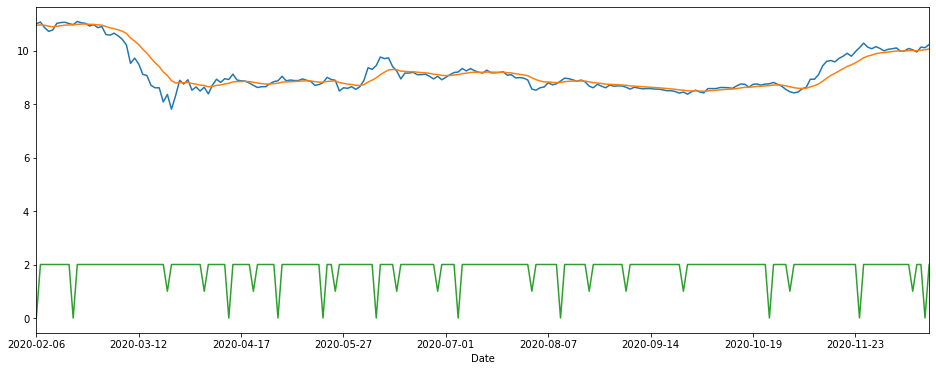

In [103]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [104]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [106]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [107]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [108]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.7116 - mean_squared_error: 2.2605 - weighted_accuracy: 0.7116 - weighted_mean_squared_error: 2.2605
Test loss: 0.13648071885108948
Test accuracy: 0.7116279006004333


In [109]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 159, 1: 32, 0: 24})

In [110]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [111]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            2       2

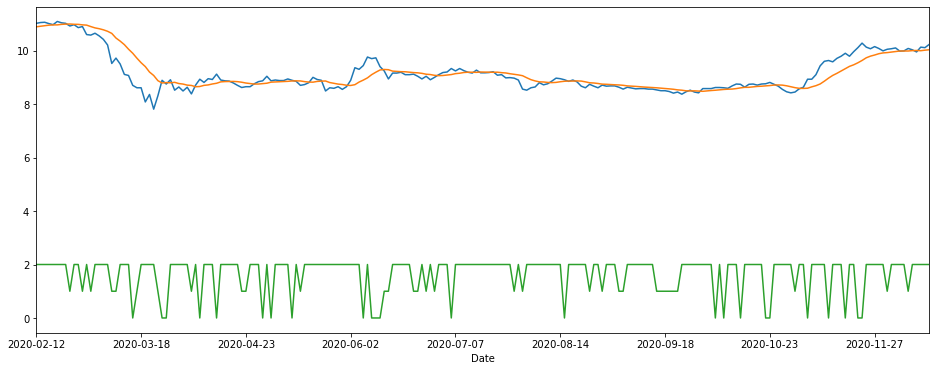

In [112]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

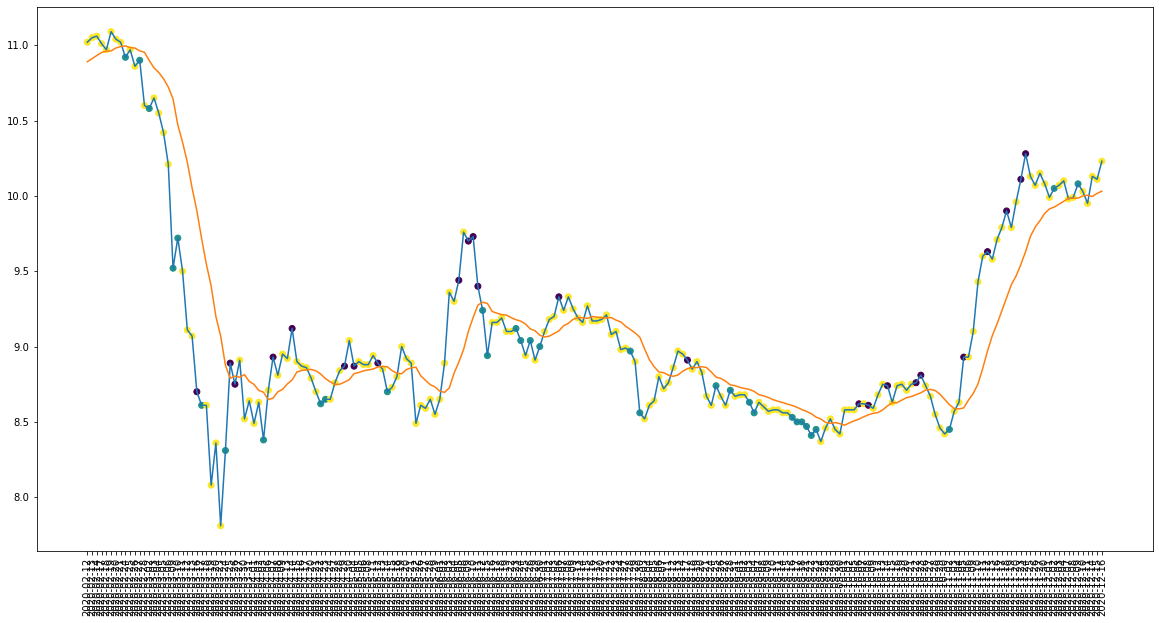

In [113]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

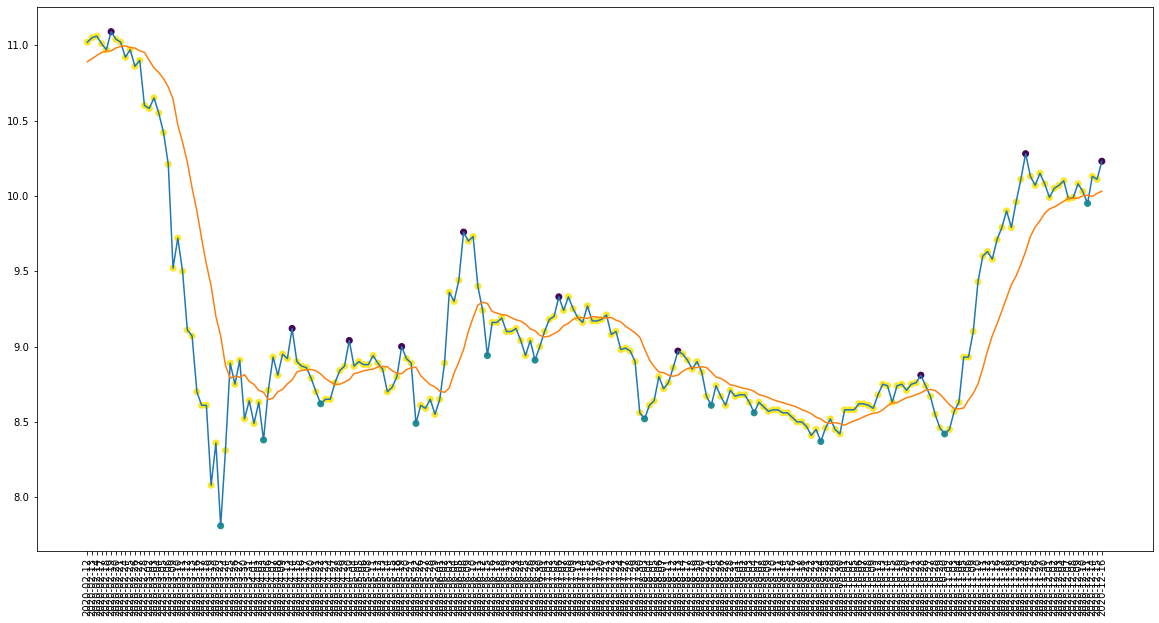

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [115]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 28
actual holds but predicted sell: 20
actual predicted holds: 145
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 40.0%
Percentage holds correct: 75.12953367875647%
actual buys: 12
actual sells: 10
actual holds: 193


In [116]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 65.625%
Percentage sells correct: 83.33333333333333%
Percentage holds correct: 86.70886075949367%


In [117]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.920000076293944
Shares owned at the moment: 913
Cash capital at the moment: $2.6225401520750893


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9653.80893747616


Share price: $10.579999923706056
Shares owned at the moment: 909
Cash capital at the moment: $10.14165201807009


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9265.50923909831


Share price: $9.520000457763672
Shares owned at the moment: 970
Cash capital at the moment: $5.7141938464628765


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $8818.112936739204


Share price: $8.609999656677246
Shares owned at the moment: 1021
Cash capital at the moment: $3.1285607357003755


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8230.121863053797


Share pric

In [118]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [308]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


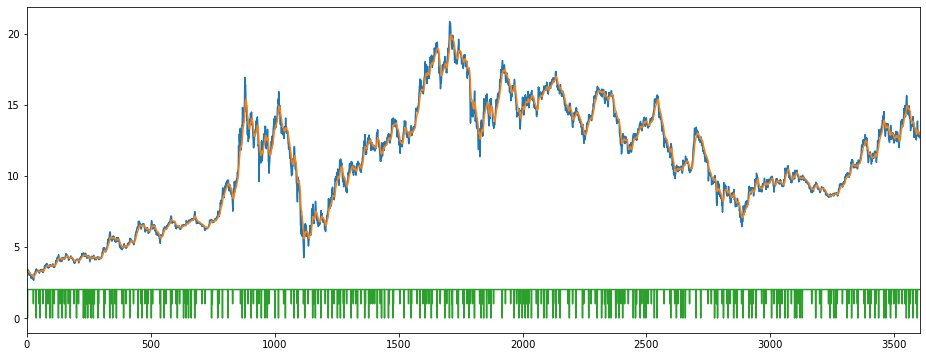

In [309]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [310]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [311]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [312]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [313]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [314]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3600, 64, 64, 1)

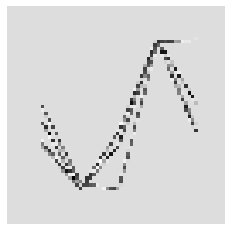

In [315]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [316]:
X = X/255

In [317]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [318]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [319]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [400]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [401]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2727272727272725, 1: 7.384615384615385, 2: 0.36669213139801377}
Epoch 1/200
23/23 [==============================] - 2s 84ms/step - loss: 0.2648 - accuracy: 0.3017 - mse: 1.9053 - weighted_accuracy: 0.3258 - weighted_mse: 2.0574 - val_loss: 0.1933 - val_accuracy: 0.0736 - val_mse: 0.8529 - val_weighted_accuracy: 0.0736 - val_weighted_mse: 0.8529
Epoch 2/200
23/23 [==============================] - 0s 12ms/step - loss: 0.2049 - accuracy: 0.3833 - mse: 1.2125 - weighted_accuracy: 0.3296 - weighted_mse: 1.2139 - val_loss: 0.1960 - val_accuracy: 0.4264 - val_mse: 0.9536 - val_weighted_accuracy: 0.4264 - val_weighted_mse: 0.9536
Epoch 3/200
23/23 [==============================] - 0s 12ms/step - loss: 0.2013 - accuracy: 0.3913 - mse: 1.1876 - weighted_accuracy: 0.3738 - weighted_mse: 1.1969 - val_loss: 0.1934 - val_accuracy: 0.7403 - val_mse: 0.8538 - val_weighted_accuracy: 0.7403 - val_weighted_mse: 0.8538
Epoch 4/200
23/23 [==============================] - 0s 13ms/step - loss: 0.20

23/23 [==============================] - 0s 12ms/step - loss: 0.1855 - accuracy: 0.2899 - mse: 1.2450 - weighted_accuracy: 0.5081 - weighted_mse: 1.2278 - val_loss: 0.2134 - val_accuracy: 0.0903 - val_mse: 0.9747 - val_weighted_accuracy: 0.0903 - val_weighted_mse: 0.9747
Epoch 29/200
23/23 [==============================] - 0s 12ms/step - loss: 0.1839 - accuracy: 0.3427 - mse: 1.2851 - weighted_accuracy: 0.5444 - weighted_mse: 1.2452 - val_loss: 0.1950 - val_accuracy: 0.2250 - val_mse: 1.0165 - val_weighted_accuracy: 0.2250 - val_weighted_mse: 1.0165
Epoch 30/200
23/23 [==============================] - 0s 13ms/step - loss: 0.1813 - accuracy: 0.2542 - mse: 1.2628 - weighted_accuracy: 0.5361 - weighted_mse: 1.2425 - val_loss: 0.1927 - val_accuracy: 0.2639 - val_mse: 1.0702 - val_weighted_accuracy: 0.2639 - val_weighted_mse: 1.0702
Epoch 31/200
23/23 [==============================] - 0s 12ms/step - loss: 0.1792 - accuracy: 0.2962 - mse: 1.3290 - weighted_accuracy: 0.5415 - weighted_mse:

Epoch 57/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1672 - accuracy: 0.3073 - mse: 1.3687 - weighted_accuracy: 0.6158 - weighted_mse: 1.3105 - val_loss: 0.1996 - val_accuracy: 0.2306 - val_mse: 1.1623 - val_weighted_accuracy: 0.2306 - val_weighted_mse: 1.1623
Epoch 58/200
23/23 [==============================] - 0s 12ms/step - loss: 0.1667 - accuracy: 0.2576 - mse: 1.3977 - weighted_accuracy: 0.6048 - weighted_mse: 1.3676 - val_loss: 0.2016 - val_accuracy: 0.2389 - val_mse: 1.0654 - val_weighted_accuracy: 0.2389 - val_weighted_mse: 1.0654
Epoch 59/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1633 - accuracy: 0.2885 - mse: 1.4990 - weighted_accuracy: 0.5991 - weighted_mse: 1.4439 - val_loss: 0.1938 - val_accuracy: 0.2597 - val_mse: 1.0662 - val_weighted_accuracy: 0.2597 - val_weighted_mse: 1.0662
Epoch 60/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1656 - accuracy: 0.3434 - mse: 1.4438 - weighted_accuracy: 0.6266 - 

Epoch 86/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1488 - accuracy: 0.3378 - mse: 1.5353 - weighted_accuracy: 0.6413 - weighted_mse: 1.5189 - val_loss: 0.1773 - val_accuracy: 0.4458 - val_mse: 1.3320 - val_weighted_accuracy: 0.4458 - val_weighted_mse: 1.3320
Epoch 87/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1496 - accuracy: 0.3569 - mse: 1.5132 - weighted_accuracy: 0.6725 - weighted_mse: 1.5229 - val_loss: 0.1817 - val_accuracy: 0.3764 - val_mse: 1.2622 - val_weighted_accuracy: 0.3764 - val_weighted_mse: 1.2622
Epoch 88/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1479 - accuracy: 0.3472 - mse: 1.6052 - weighted_accuracy: 0.6567 - weighted_mse: 1.5932 - val_loss: 0.1881 - val_accuracy: 0.3153 - val_mse: 1.2506 - val_weighted_accuracy: 0.3153 - val_weighted_mse: 1.2506
Epoch 89/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1489 - accuracy: 0.3483 - mse: 1.4910 - weighted_accuracy: 0.6618 - 

Epoch 115/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1335 - accuracy: 0.4115 - mse: 1.7655 - weighted_accuracy: 0.7144 - weighted_mse: 1.8410 - val_loss: 0.1752 - val_accuracy: 0.4153 - val_mse: 1.4332 - val_weighted_accuracy: 0.4153 - val_weighted_mse: 1.4332
Epoch 116/200
23/23 [==============================] - 0s 12ms/step - loss: 0.1354 - accuracy: 0.4583 - mse: 1.6224 - weighted_accuracy: 0.7121 - weighted_mse: 1.6917 - val_loss: 0.1868 - val_accuracy: 0.3597 - val_mse: 1.4589 - val_weighted_accuracy: 0.3597 - val_weighted_mse: 1.4589
Epoch 117/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1324 - accuracy: 0.4028 - mse: 1.6697 - weighted_accuracy: 0.7087 - weighted_mse: 1.7542 - val_loss: 0.1733 - val_accuracy: 0.4611 - val_mse: 1.3815 - val_weighted_accuracy: 0.4611 - val_weighted_mse: 1.3815
Epoch 118/200
23/23 [==============================] - 0s 12ms/step - loss: 0.1280 - accuracy: 0.4618 - mse: 1.7071 - weighted_accuracy: 0.739

Epoch 144/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1116 - accuracy: 0.5517 - mse: 1.9456 - weighted_accuracy: 0.7946 - weighted_mse: 2.2359 - val_loss: 0.1596 - val_accuracy: 0.5319 - val_mse: 1.6200 - val_weighted_accuracy: 0.5319 - val_weighted_mse: 1.6200
Epoch 145/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1134 - accuracy: 0.5448 - mse: 1.9277 - weighted_accuracy: 0.7971 - weighted_mse: 2.2364 - val_loss: 0.1397 - val_accuracy: 0.6486 - val_mse: 1.5127 - val_weighted_accuracy: 0.6486 - val_weighted_mse: 1.5127
Epoch 146/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1172 - accuracy: 0.5566 - mse: 1.8037 - weighted_accuracy: 0.7700 - weighted_mse: 2.0562 - val_loss: 0.1449 - val_accuracy: 0.6278 - val_mse: 1.4727 - val_weighted_accuracy: 0.6278 - val_weighted_mse: 1.4727
Epoch 147/200
23/23 [==============================] - 0s 11ms/step - loss: 0.1148 - accuracy: 0.5556 - mse: 1.8389 - weighted_accuracy: 0.781

Epoch 173/200
23/23 [==============================] - 0s 12ms/step - loss: 0.1010 - accuracy: 0.6476 - mse: 2.1427 - weighted_accuracy: 0.8251 - weighted_mse: 2.5892 - val_loss: 0.1214 - val_accuracy: 0.7375 - val_mse: 1.7766 - val_weighted_accuracy: 0.7375 - val_weighted_mse: 1.7766
Epoch 174/200
23/23 [==============================] - 0s 12ms/step - loss: 0.0997 - accuracy: 0.6559 - mse: 2.0435 - weighted_accuracy: 0.8281 - weighted_mse: 2.4717 - val_loss: 0.1373 - val_accuracy: 0.6667 - val_mse: 1.7631 - val_weighted_accuracy: 0.6667 - val_weighted_mse: 1.7631
Epoch 175/200
23/23 [==============================] - 0s 13ms/step - loss: 0.0980 - accuracy: 0.6385 - mse: 2.1803 - weighted_accuracy: 0.8264 - weighted_mse: 2.7180 - val_loss: 0.1376 - val_accuracy: 0.6542 - val_mse: 1.7478 - val_weighted_accuracy: 0.6542 - val_weighted_mse: 1.7478
Epoch 176/200
23/23 [==============================] - 0s 12ms/step - loss: 0.0979 - accuracy: 0.6569 - mse: 2.1061 - weighted_accuracy: 0.823

In [402]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11528512090444565
Test accuracy: 0.7638888955116272


In [403]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.0867134  -0.9003552  -0.32945293]
 [-1.6489272  -1.0812665   0.3743118 ]
 [-1.069959   -1.163859    0.24995896]
 ...
 [-1.7391317  -2.160117    0.87209463]
 [-1.9667075  -0.4332162  -0.27246708]
 [-0.45168072 -2.8226514  -0.1864371 ]]


Counter({2: 583, 0: 58, 1: 79})

In [404]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 655, 0: 33, 1: 32})

In [405]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 720
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 23
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 26
actual holds but predicted buy: 70
actual holds but predicted sell: 51
actual predicted holds: 534
Percentage buys correct: 28.125%
Percentage sells correct: 21.21212121212121%
Percentage holds correct: 81.52671755725191%
actual buys: 32
actual sells: 33
actual holds: 655


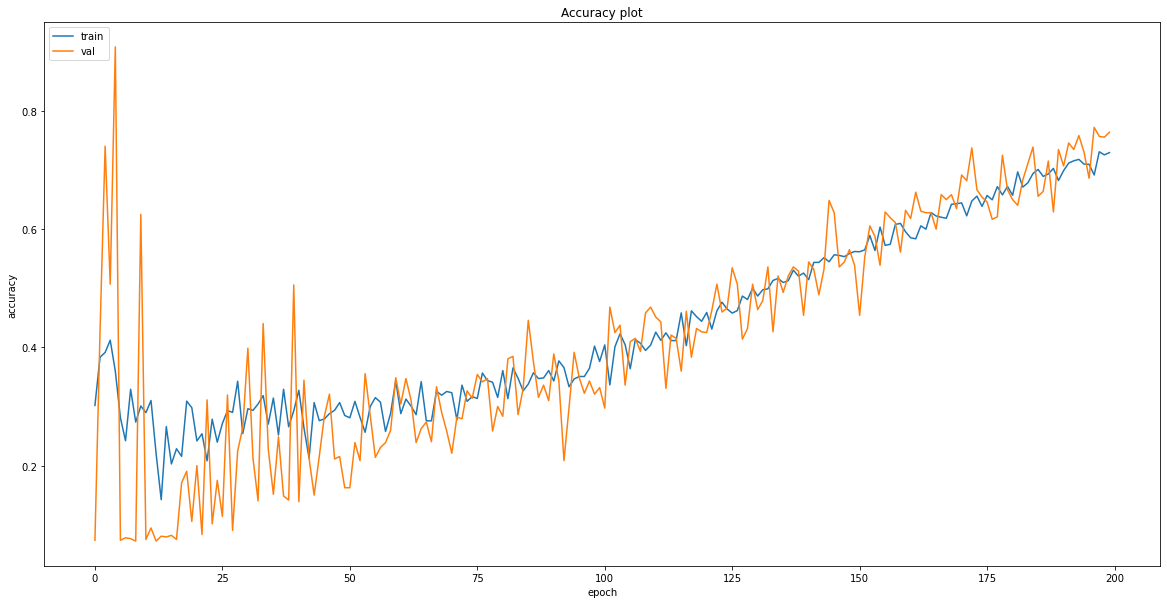

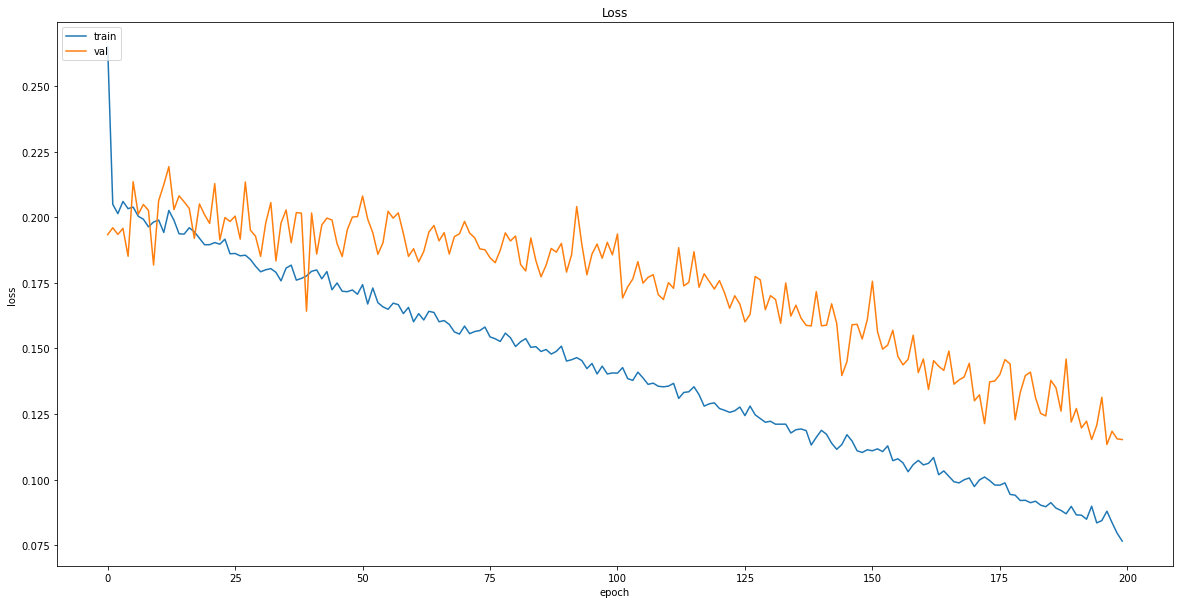

In [406]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [407]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

#### Non-Recession

In [408]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-02-08        13.20  12.920431  -9.302320  507661024.0     2.0
2019-02-11        12.88  12.914211 -46.511602  447901134.0     2.0
2019-02-12        12.90  12.912024 -54.285745  495941238.0     2.0
2019-02-13        13.08  12.937867 -28.571409  545190223.0     2.0
2019-02-14        13.38  13.005887  -9.090899  594167146.0     2.0

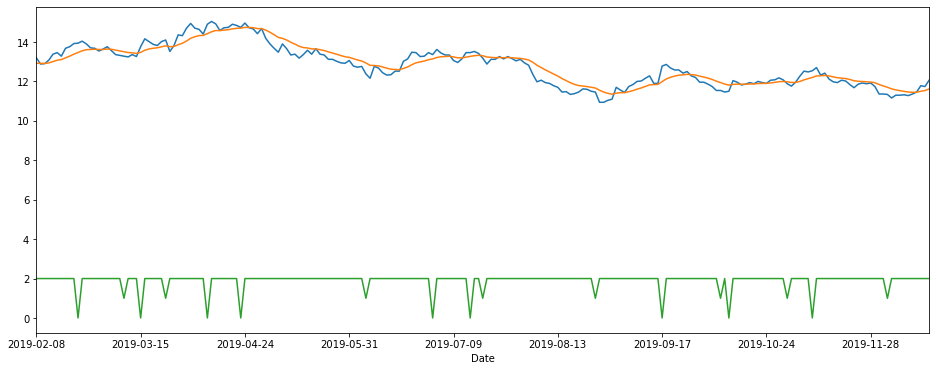

In [409]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [410]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [411]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [412]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [413]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [414]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1103 - accuracy: 0.7962 - mean_squared_error: 1.9773 - weighted_accuracy: 0.7962 - weighted_mean_squared_error: 1.9773
Test loss: 0.11025835573673248
Test accuracy: 0.7962085604667664


In [415]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 0: 12, 1: 22})

In [416]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [417]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            2       2  
2019-02-15            2       2  
2019-02-18            2       2  
2019-02-19            0       2  
2019-02-20            2       2

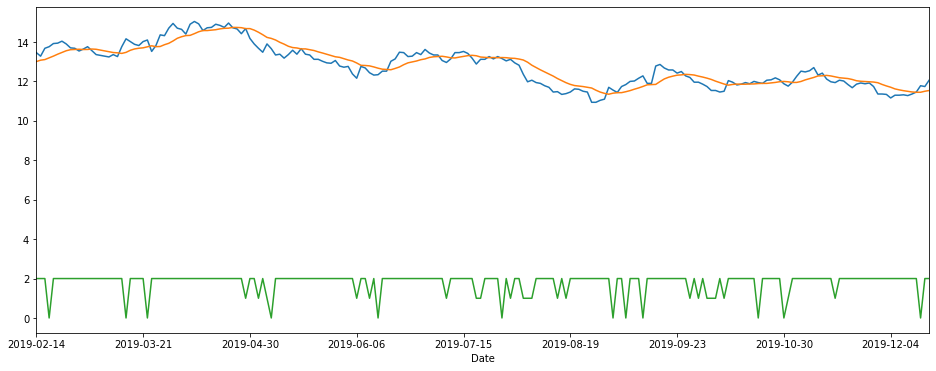

In [418]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

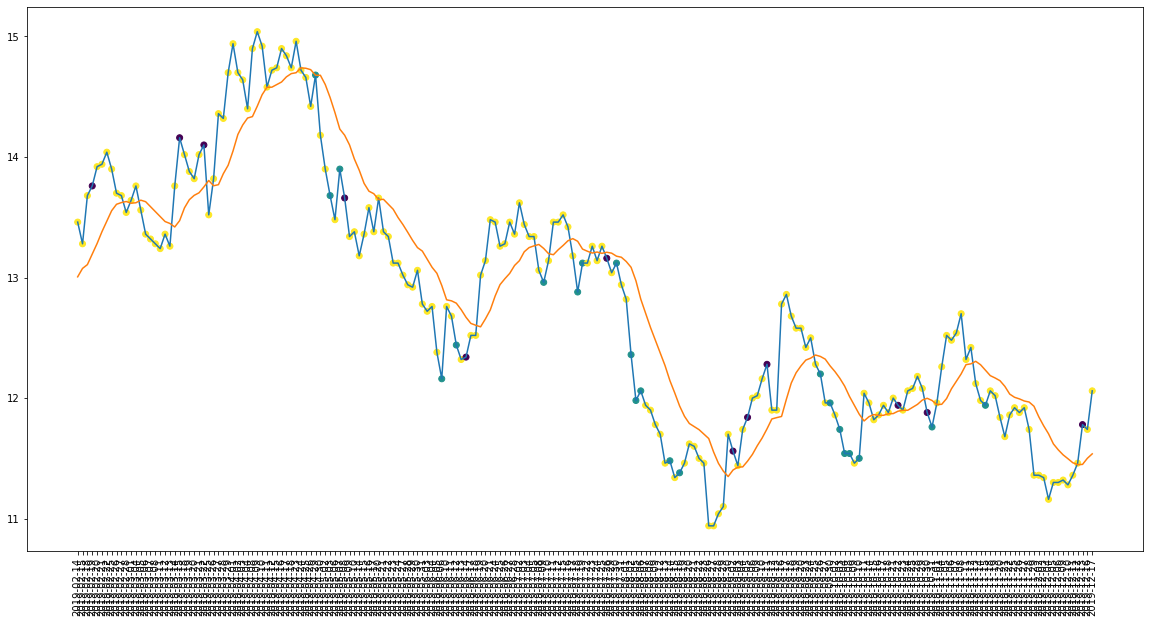

In [419]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

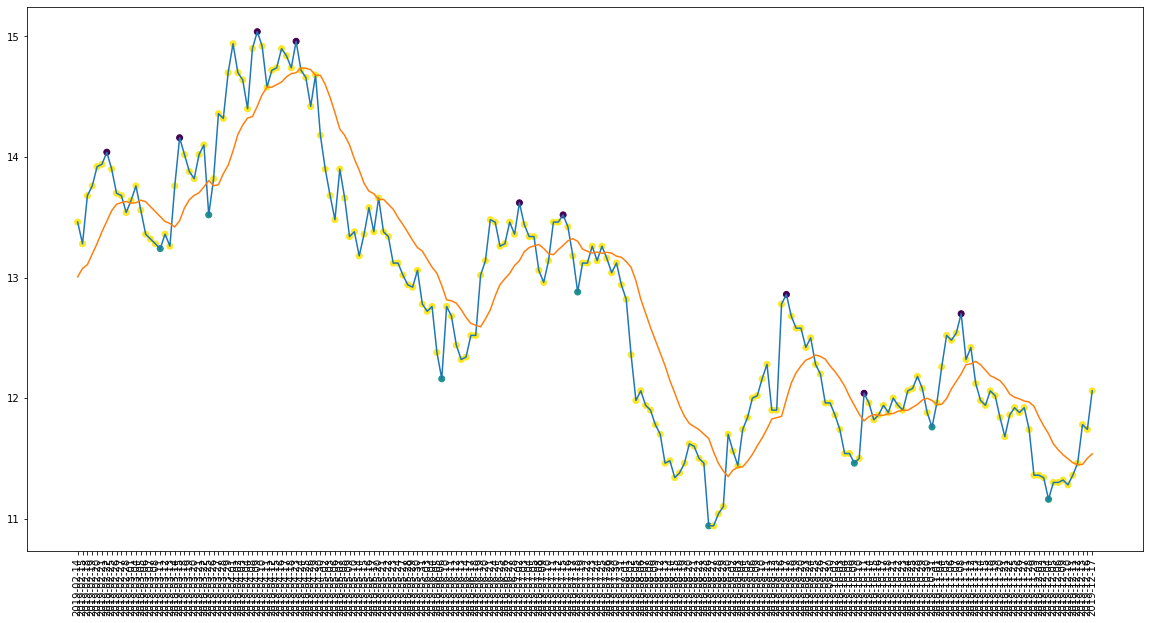

In [420]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [421]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 19
actual holds but predicted sell: 11
actual predicted holds: 164
Percentage buys correct: 37.5%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 84.5360824742268%
actual buys: 8
actual sells: 9
actual holds: 194


In [422]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 50.0%
Percentage holds correct: 81.81818181818181%


In [423]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.68000030517578
Shares owned at the moment: 679
Cash capital at the moment: $4.868562215806378


Stop Loss Activated!

Share price: $14.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9606.61116386032


Share price: $13.68000030517578
Shares owned at the moment: 700
Cash capital at the moment: $4.276949649811286


Stop Loss Activated!

Share price: $13.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9204.905662685393


Share price: $12.15999984741211
Shares owned at the moment: 754
Cash capital at the moment: $11.052018053052961


Price increase from previously bought: 7.926885378927895%
Share price: $13.15999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9906.404643318174


Share price: $13.119999885559082
Shares owned at the moment: 752
Cash capital at the moment: $13.032569614408203


Stop Loss Activated!

Share price: $12.359999656677244
Shares owned at the moment: 0
Cash capital at the moment

In [424]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [425]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-02-07        12.60  12.453556 -47.619039  117731211.0     2.0
2020-02-10        12.26  12.423778 -63.809519   69675784.0     2.0
2020-02-11        12.18  12.386274 -67.619039   33507859.0     2.0
2020-02-12        12.32  12.376078 -56.842113   67402284.0     2.0
2020-02-13        12.44  12.385912 -50.526328  113135355.0     2.0

In [426]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [427]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [428]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [429]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [430]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1240 - accuracy: 0.7606 - mean_squared_error: 2.1060 - weighted_accuracy: 0.7606 - weighted_mean_squared_error: 2.1060
Test loss: 0.1239960789680481
Test accuracy: 0.7605633735656738


In [431]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 172, 1: 27, 0: 14})

In [432]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [433]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            2       2  
2020-02-19            1       2

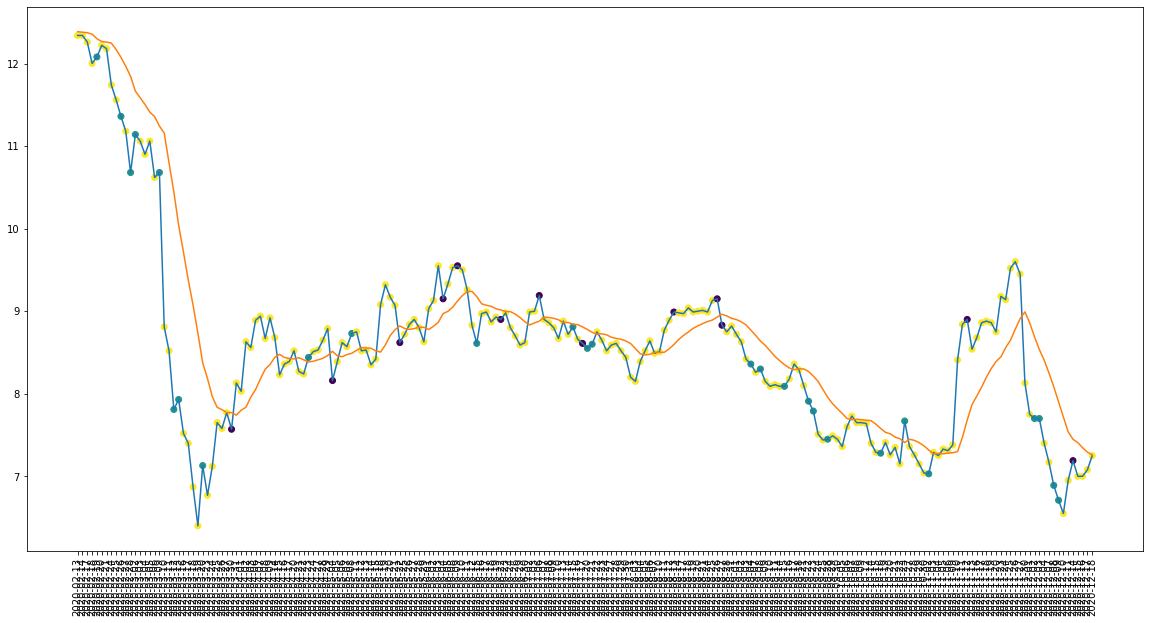

In [434]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

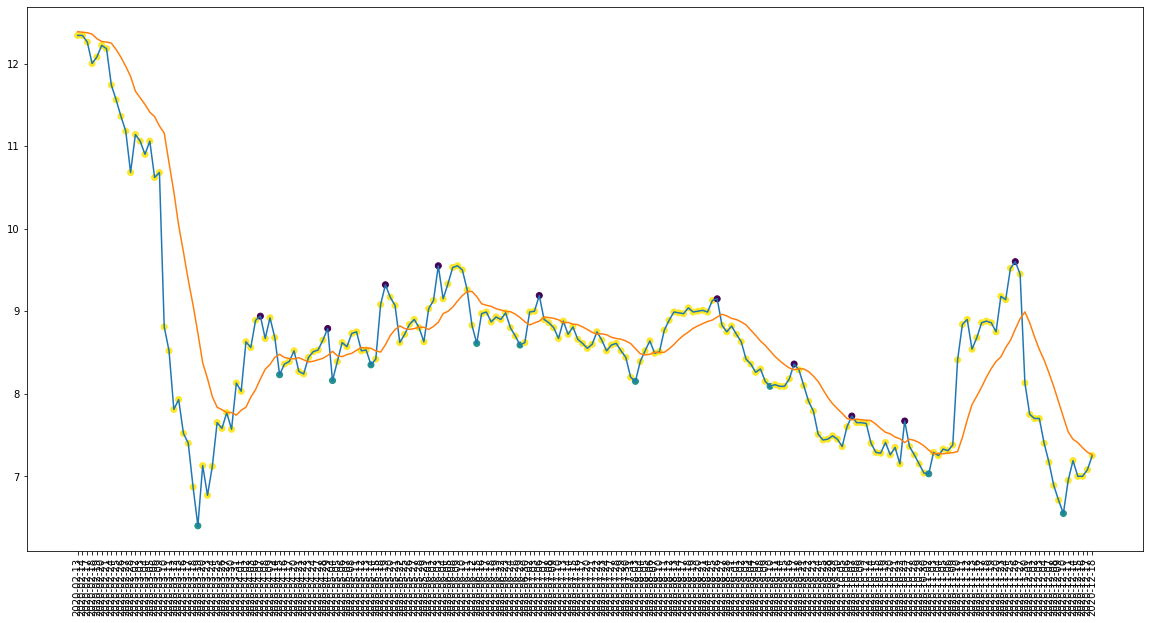

In [435]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [436]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 24
actual holds but predicted sell: 11
actual predicted holds: 158
Percentage buys correct: 20.0%
Percentage sells correct: 20.0%
Percentage holds correct: 81.86528497409327%
actual buys: 10
actual sells: 10
actual holds: 193


In [437]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 51.851851851851855%
Percentage sells correct: 46.15384615384615%
Percentage holds correct: 84.88372093023256%


In [438]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.079999923706055
Shares owned at the moment: 825
Cash capital at the moment: $6.593563115597135


Stop Loss Activated!

Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9665.458249807358


Share price: $11.359999656677244
Shares owned at the moment: 848
Cash capital at the moment: $5.6870217456835235


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9037.421519823074


Share price: $10.68000030517578
Shares owned at the moment: 843
Cash capital at the moment: $9.422351852417705


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7415.828922116519


Share price: $7.809999942779541
Shares owned at the moment: 946
Cash capital at the moment: $7.251261395931579


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7101.607963402033


Share price: $

In [439]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [171]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


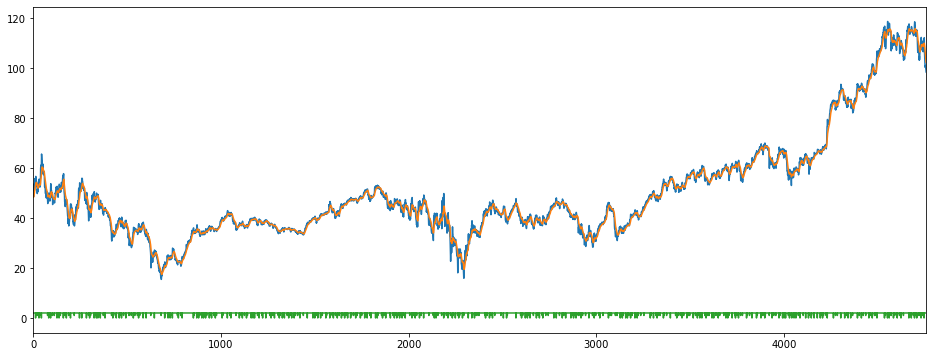

In [172]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [173]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [174]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [175]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [177]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4755, 64, 64, 1)

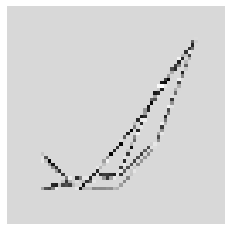

In [178]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [179]:
X = X/255

In [180]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [181]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [182]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [183]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [184]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.684848484848485, 1: 7.415204678362573, 2: 0.36562860438292966}
Epoch 1/200
30/30 [==============================] - 2s 71ms/step - loss: 0.2500 - accuracy: 0.3467 - mse: 1.6644 - weighted_accuracy: 0.3154 - weighted_mse: 1.7530 - val_loss: 0.2301 - val_accuracy: 0.0431 - val_mse: 1.0636 - val_weighted_accuracy: 0.0431 - val_weighted_mse: 1.0636
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2043 - accuracy: 0.2416 - mse: 1.1867 - weighted_accuracy: 0.3479 - weighted_mse: 1.1770 - val_loss: 0.2106 - val_accuracy: 0.0620 - val_mse: 0.9095 - val_weighted_accuracy: 0.0620 - val_weighted_mse: 0.9095
Epoch 3/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2037 - accuracy: 0.2666 - mse: 1.1406 - weighted_accuracy: 0.3550 - weighted_mse: 1.1460 - val_loss: 0.2233 - val_accuracy: 0.0431 - val_mse: 0.9482 - val_weighted_accuracy: 0.0431 - val_weighted_mse: 0.9482
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.204

30/30 [==============================] - 0s 9ms/step - loss: 0.1761 - accuracy: 0.1717 - mse: 1.4752 - weighted_accuracy: 0.5310 - weighted_mse: 1.3810 - val_loss: 0.2047 - val_accuracy: 0.0789 - val_mse: 1.0964 - val_weighted_accuracy: 0.0789 - val_weighted_mse: 1.0964
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1752 - accuracy: 0.1627 - mse: 1.4114 - weighted_accuracy: 0.5404 - weighted_mse: 1.3344 - val_loss: 0.2013 - val_accuracy: 0.0799 - val_mse: 1.1291 - val_weighted_accuracy: 0.0799 - val_weighted_mse: 1.1291
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1726 - accuracy: 0.1866 - mse: 1.4834 - weighted_accuracy: 0.5519 - weighted_mse: 1.4306 - val_loss: 0.2000 - val_accuracy: 0.0715 - val_mse: 1.1589 - val_weighted_accuracy: 0.0715 - val_weighted_mse: 1.1589
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1728 - accuracy: 0.1585 - mse: 1.4674 - weighted_accuracy: 0.5465 - weighted_mse: 1.

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1632 - accuracy: 0.1880 - mse: 1.5854 - weighted_accuracy: 0.5766 - weighted_mse: 1.5160 - val_loss: 0.2022 - val_accuracy: 0.1030 - val_mse: 1.2820 - val_weighted_accuracy: 0.1030 - val_weighted_mse: 1.2820
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1574 - accuracy: 0.1759 - mse: 1.6394 - weighted_accuracy: 0.5946 - weighted_mse: 1.6186 - val_loss: 0.2021 - val_accuracy: 0.1073 - val_mse: 1.3010 - val_weighted_accuracy: 0.1073 - val_weighted_mse: 1.3010
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1629 - accuracy: 0.1827 - mse: 1.5752 - weighted_accuracy: 0.5823 - weighted_mse: 1.5248 - val_loss: 0.2024 - val_accuracy: 0.1094 - val_mse: 1.4193 - val_weighted_accuracy: 0.1094 - val_weighted_mse: 1.4193
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1600 - accuracy: 0.1714 - mse: 1.5935 - weighted_accuracy: 0.6010 - we

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1503 - accuracy: 0.2164 - mse: 1.7759 - weighted_accuracy: 0.6364 - weighted_mse: 1.7462 - val_loss: 0.1987 - val_accuracy: 0.1577 - val_mse: 1.4390 - val_weighted_accuracy: 0.1577 - val_weighted_mse: 1.4390
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1495 - accuracy: 0.2190 - mse: 1.7493 - weighted_accuracy: 0.6366 - weighted_mse: 1.7333 - val_loss: 0.2019 - val_accuracy: 0.1420 - val_mse: 1.4711 - val_weighted_accuracy: 0.1420 - val_weighted_mse: 1.4711
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1461 - accuracy: 0.2250 - mse: 1.7420 - weighted_accuracy: 0.6564 - weighted_mse: 1.7297 - val_loss: 0.2030 - val_accuracy: 0.1725 - val_mse: 1.7089 - val_weighted_accuracy: 0.1725 - val_weighted_mse: 1.7089
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1447 - accuracy: 0.2245 - mse: 1.8221 - weighted_accuracy: 0.6446 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1343 - accuracy: 0.3215 - mse: 1.9948 - weighted_accuracy: 0.6990 - weighted_mse: 2.0920 - val_loss: 0.1976 - val_accuracy: 0.2576 - val_mse: 1.8125 - val_weighted_accuracy: 0.2576 - val_weighted_mse: 1.8125
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.3194 - mse: 2.0187 - weighted_accuracy: 0.7057 - weighted_mse: 2.1593 - val_loss: 0.1948 - val_accuracy: 0.2860 - val_mse: 1.8230 - val_weighted_accuracy: 0.2860 - val_weighted_mse: 1.8230
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1338 - accuracy: 0.3297 - mse: 2.0506 - weighted_accuracy: 0.6945 - weighted_mse: 2.1708 - val_loss: 0.1954 - val_accuracy: 0.2881 - val_mse: 1.9344 - val_weighted_accuracy: 0.2881 - val_weighted_mse: 1.9344
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1326 - accuracy: 0.3483 - mse: 2.0697 - weighted_accuracy: 0.7012 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1182 - accuracy: 0.5011 - mse: 2.3443 - weighted_accuracy: 0.7701 - weighted_mse: 2.6354 - val_loss: 0.1800 - val_accuracy: 0.4543 - val_mse: 1.9795 - val_weighted_accuracy: 0.4543 - val_weighted_mse: 1.9795
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1179 - accuracy: 0.5000 - mse: 2.3508 - weighted_accuracy: 0.7642 - weighted_mse: 2.7462 - val_loss: 0.1736 - val_accuracy: 0.4890 - val_mse: 1.9906 - val_weighted_accuracy: 0.4890 - val_weighted_mse: 1.9906
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1163 - accuracy: 0.5258 - mse: 2.4094 - weighted_accuracy: 0.7774 - weighted_mse: 2.8193 - val_loss: 0.1742 - val_accuracy: 0.4784 - val_mse: 2.1595 - val_weighted_accuracy: 0.4784 - val_weighted_mse: 2.1595
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1129 - accuracy: 0.5050 - mse: 2.4911 - weighted_accuracy: 0.7830 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1001 - accuracy: 0.6046 - mse: 2.8443 - weighted_accuracy: 0.8134 - weighted_mse: 3.5638 - val_loss: 0.1529 - val_accuracy: 0.6046 - val_mse: 2.3991 - val_weighted_accuracy: 0.6046 - val_weighted_mse: 2.3991
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0997 - accuracy: 0.6446 - mse: 2.8177 - weighted_accuracy: 0.8281 - weighted_mse: 3.5188 - val_loss: 0.1629 - val_accuracy: 0.5657 - val_mse: 2.4390 - val_weighted_accuracy: 0.5657 - val_weighted_mse: 2.4390
Epoch 175/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1013 - accuracy: 0.6217 - mse: 2.8779 - weighted_accuracy: 0.8123 - weighted_mse: 3.6223 - val_loss: 0.1536 - val_accuracy: 0.6393 - val_mse: 2.3634 - val_weighted_accuracy: 0.6393 - val_weighted_mse: 2.3634
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1000 - accuracy: 0.6451 - mse: 2.8755 - weighted_accuracy: 0.8286 

In [185]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.136264830827713
Test accuracy: 0.7308096885681152


In [186]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.3268611  -1.2279364  -0.02407315]
 [-0.3706618  -2.7705615  -0.36142462]
 [-1.0026692  -2.3038445  -0.02911015]
 ...
 [-1.8715333  -1.4558437   0.04455256]
 [-2.5780334  -1.3820419   0.12004112]
 [-2.4053178  -1.6557269   0.10682988]]


Counter({2: 736, 1: 111, 0: 104})

In [187]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 41, 1: 43})

In [188]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 32
actual sells but predicted buy: 2
actual predicted sells: 10
actual sells but predicted hold: 29
actual holds but predicted buy: 99
actual holds but predicted sell: 93
actual predicted holds: 675
Percentage buys correct: 23.25581395348837%
Percentage sells correct: 24.390243902439025%
Percentage holds correct: 77.85467128027682%
actual buys: 43
actual sells: 41
actual holds: 867


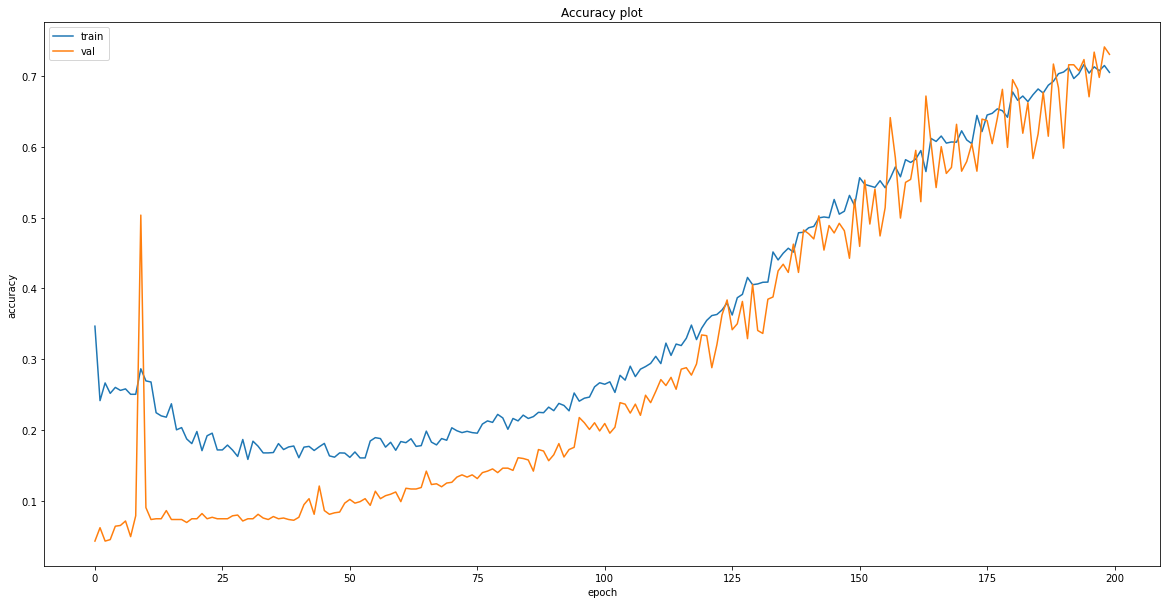

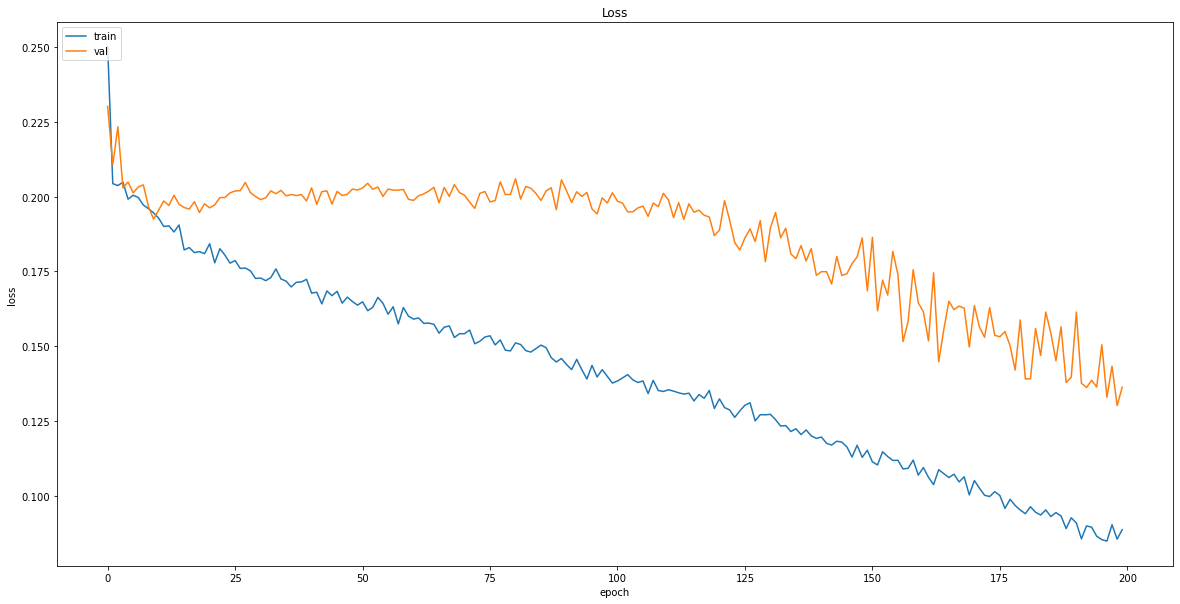

In [189]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [190]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [191]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-02-05   104.250000  103.300007 -14.909608  120675400.0     2.0
2019-02-06   103.790001  103.375391 -42.151138  107912400.0     2.0
2019-02-07   103.739998  103.431484 -45.180727   99167400.0     2.0
2019-02-08   102.379997  103.269717 -75.263265   85989900.0     2.0
2019-02-11   101.360001  102.975915 -74.903417   73097300.0     1.0

In [192]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [194]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [195]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [196]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1403 - accuracy: 0.7064 - mean_squared_error: 2.7954 - weighted_accuracy: 0.7064 - weighted_mean_squared_error: 2.7954
Test loss: 0.14027562737464905
Test accuracy: 0.7064220309257507


In [197]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 26, 2: 164, 0: 28})

In [198]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [199]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            0       2

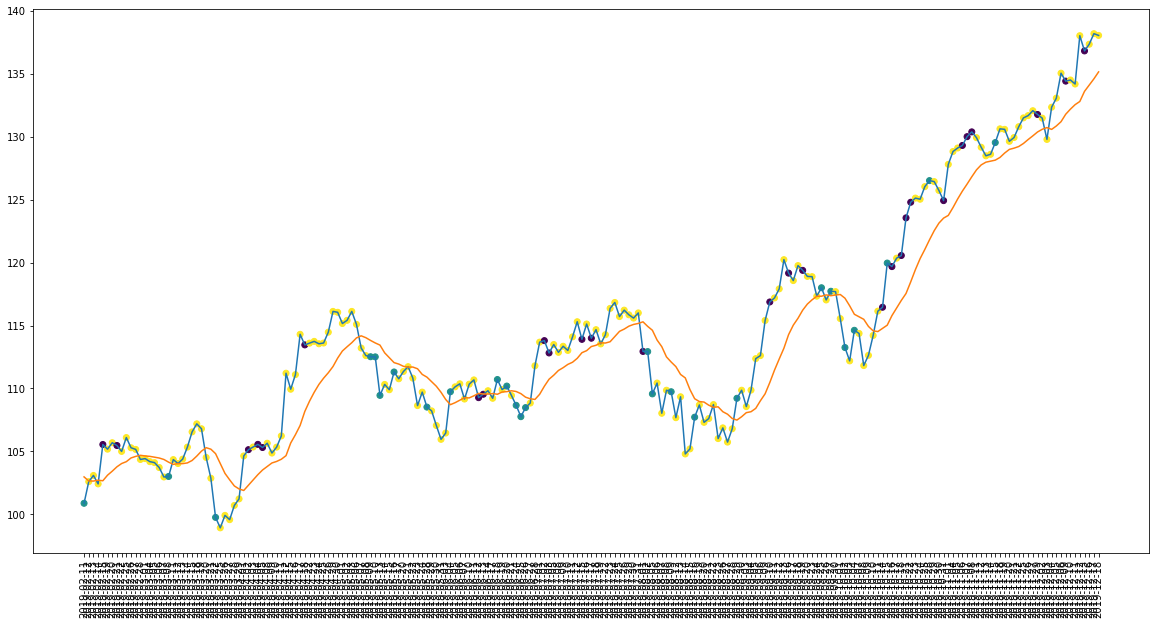

In [200]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

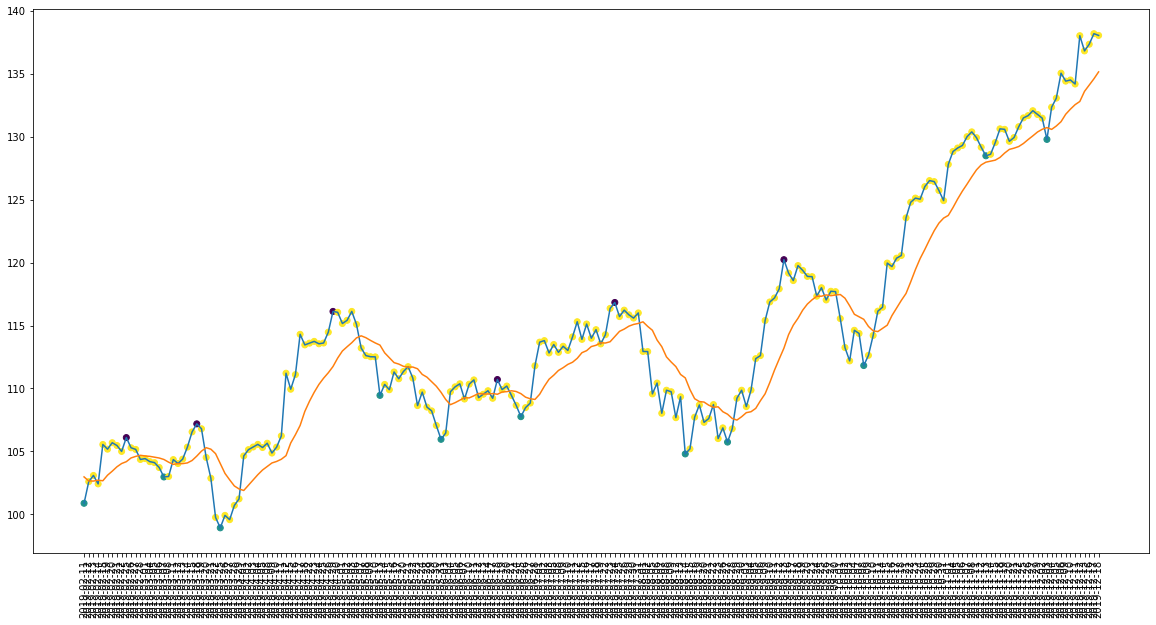

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [202]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 5
actual holds but predicted buy: 22
actual holds but predicted sell: 28
actual predicted holds: 151
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 0.0%
Percentage holds correct: 75.12437810945273%
actual buys: 11
actual sells: 6
actual holds: 201


In [203]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 38.46153846153846%
Percentage sells correct: 35.714285714285715%
Percentage holds correct: 85.2760736196319%


In [204]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.87999725341795
Shares owned at the moment: 98
Cash capital at the moment: $86.57310990524456


Price increase from previously bought: 12.161818849829032%
Share price: $113.45999908447266
Shares owned at the moment: 0
Cash capital at the moment: $11175.0755504303


Share price: $112.5199966430664
Shares owned at the moment: 99
Cash capital at the moment: $4.9623136806494585


Stop Loss Activated!

Share price: $108.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10730.745013422013


Share price: $108.5199966430664
Shares owned at the moment: 98
Cash capital at the moment: $66.53920330619803


Stop Loss Activated!

Share price: $104.8000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10308.695901556013


Share price: $107.72000122070312
Shares owned at the moment: 95
Cash capital at the moment: $47.15393527030756


Price increase from previously bought: 8.196704719456882%
Share price: $116.87000274658205
Shares owned at the

In [205]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [206]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-02-05   135.289993  134.895573 -37.232993   8033700.0     2.0
2020-02-06   137.589996  135.310099  -8.158485  18184400.0     2.0
2020-02-07   137.610001  135.663930  -7.925335  27176700.0     2.0
2020-02-10   137.169998  135.895633 -13.053577  20796900.0     2.0
2020-02-11   137.740005  136.179383  -6.410124  26757600.0     0.0

In [207]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [209]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [210]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [211]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 8ms/step - loss: 0.1355 - accuracy: 0.7352 - mean_squared_error: 2.8722 - weighted_accuracy: 0.7352 - weighted_mean_squared_error: 2.8722
Test loss: 0.13549606502056122
Test accuracy: 0.7351598143577576


In [212]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 1: 24, 0: 26})

In [213]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [214]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

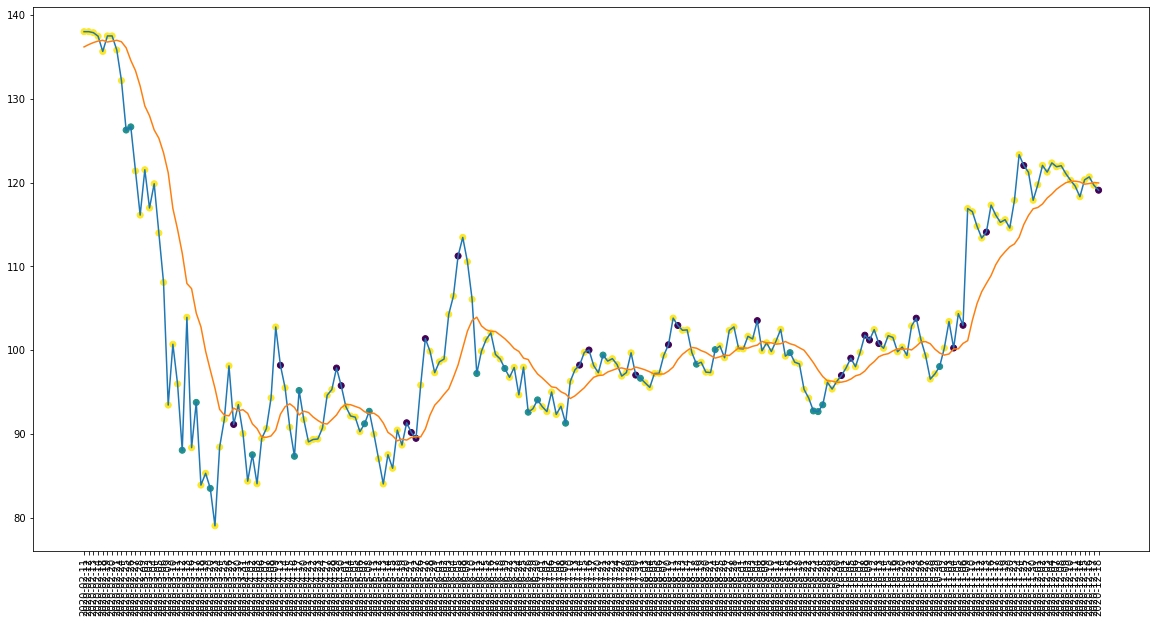

In [215]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

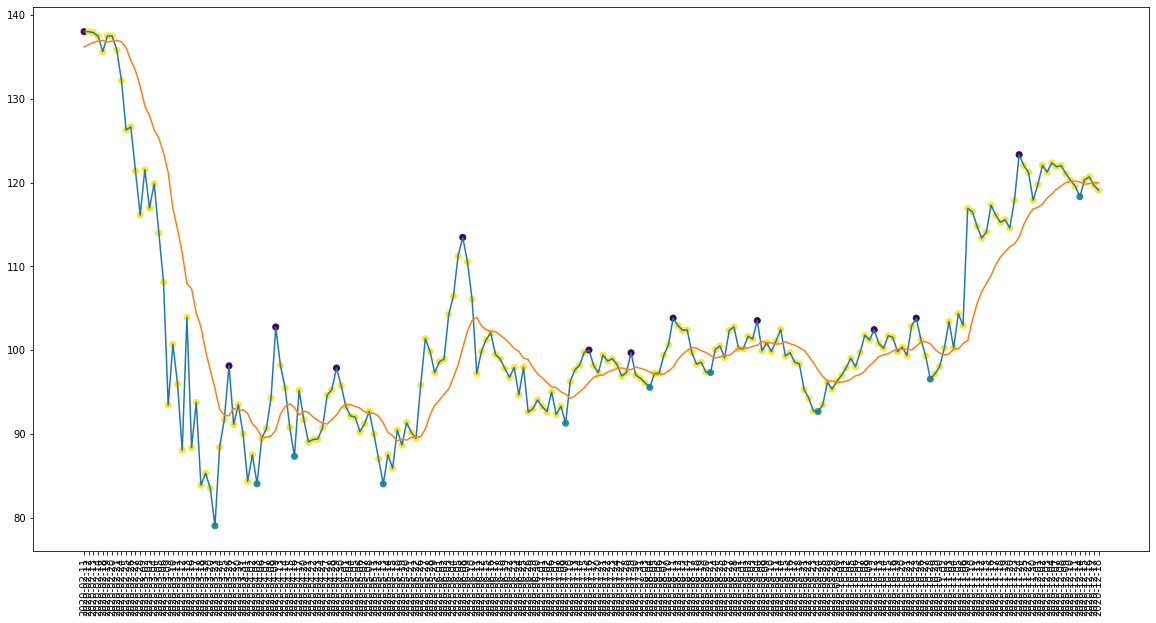

In [216]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [217]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 22
actual predicted holds: 154
Percentage buys correct: 30.0%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 78.1725888324873%
actual buys: 10
actual sells: 12
actual holds: 197


In [218]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 62.5%
Percentage sells correct: 65.38461538461539%
Percentage holds correct: 83.92857142857143%


In [219]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $126.26000213623048
Shares owned at the moment: 78
Cash capital at the moment: $124.6370629157991


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9565.463411560057


Share price: $88.05000305175781
Shares owned at the moment: 108
Cash capital at the moment: $29.91223106384132


Stop Loss Activated!

Share price: $83.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $9065.116835327146


Share price: $83.5
Shares owned at the moment: 108
Cash capital at the moment: $22.317335327144974


Stop Loss Activated!

Share price: $79.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $8534.085293853756


Share price: $87.51000213623047
Shares owned at the moment: 97
Cash capital at the moment: $22.27179356956003


Stop Loss Activated!

Share price: $84.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8152.701751276011


Share price: $87.33000183105

In [220]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [221]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


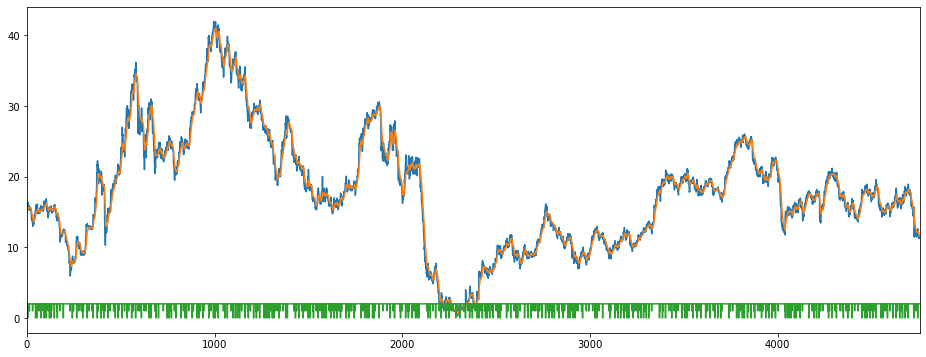

In [222]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [223]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [224]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [226]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4755, 64, 64, 1)

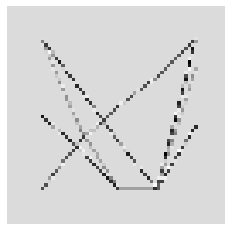

In [227]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [228]:
X = X/255

In [229]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [230]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [231]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [270]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [271]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2457142857142856, 1: 7.287356321839081, 2: 0.3670043415340087}
Epoch 1/200
30/30 [==============================] - 2s 81ms/step - loss: 0.2409 - accuracy: 0.4046 - mse: 1.7266 - weighted_accuracy: 0.3444 - weighted_mse: 1.6977 - val_loss: 0.2013 - val_accuracy: 0.0620 - val_mse: 0.9281 - val_weighted_accuracy: 0.0620 - val_weighted_mse: 0.9281
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2065 - accuracy: 0.4014 - mse: 1.1687 - weighted_accuracy: 0.3432 - weighted_mse: 1.1871 - val_loss: 0.1940 - val_accuracy: 0.5941 - val_mse: 0.8451 - val_weighted_accuracy: 0.5941 - val_weighted_mse: 0.8451
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2055 - accuracy: 0.3665 - mse: 1.1476 - weighted_accuracy: 0.3411 - weighted_mse: 1.1500 - val_loss: 0.1995 - val_accuracy: 0.2177 - val_mse: 0.8338 - val_weighted_accuracy: 0.2177 - val_weighted_mse: 0.8338
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2049

30/30 [==============================] - 0s 10ms/step - loss: 0.1818 - accuracy: 0.2355 - mse: 1.3273 - weighted_accuracy: 0.5127 - weighted_mse: 1.3138 - val_loss: 0.2024 - val_accuracy: 0.0768 - val_mse: 1.0590 - val_weighted_accuracy: 0.0768 - val_weighted_mse: 1.0590
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1824 - accuracy: 0.2221 - mse: 1.2863 - weighted_accuracy: 0.5278 - weighted_mse: 1.2468 - val_loss: 0.1988 - val_accuracy: 0.1556 - val_mse: 1.0432 - val_weighted_accuracy: 0.1556 - val_weighted_mse: 1.0432
Epoch 30/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1807 - accuracy: 0.2158 - mse: 1.3386 - weighted_accuracy: 0.5326 - weighted_mse: 1.2677 - val_loss: 0.1958 - val_accuracy: 0.1525 - val_mse: 1.1051 - val_weighted_accuracy: 0.1525 - val_weighted_mse: 1.1051
Epoch 31/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1816 - accuracy: 0.2340 - mse: 1.3203 - weighted_accuracy: 0.5357 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1664 - accuracy: 0.2726 - mse: 1.4581 - weighted_accuracy: 0.5971 - weighted_mse: 1.4224 - val_loss: 0.1966 - val_accuracy: 0.2050 - val_mse: 1.2156 - val_weighted_accuracy: 0.2050 - val_weighted_mse: 1.2156
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1647 - accuracy: 0.2781 - mse: 1.4944 - weighted_accuracy: 0.5519 - weighted_mse: 1.4884 - val_loss: 0.1996 - val_accuracy: 0.1283 - val_mse: 1.1129 - val_weighted_accuracy: 0.1283 - val_weighted_mse: 1.1129
Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1690 - accuracy: 0.1753 - mse: 1.4240 - weighted_accuracy: 0.5778 - weighted_mse: 1.3447 - val_loss: 0.1916 - val_accuracy: 0.1987 - val_mse: 1.2199 - val_weighted_accuracy: 0.1987 - val_weighted_mse: 1.2199
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1652 - accuracy: 0.2253 - mse: 1.4815 - weighted_accuracy: 0.5961 - 

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1506 - accuracy: 0.3197 - mse: 1.5792 - weighted_accuracy: 0.6306 - weighted_mse: 1.5758 - val_loss: 0.1892 - val_accuracy: 0.2797 - val_mse: 1.3138 - val_weighted_accuracy: 0.2797 - val_weighted_mse: 1.3138
Epoch 87/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1451 - accuracy: 0.3523 - mse: 1.6376 - weighted_accuracy: 0.6680 - weighted_mse: 1.6257 - val_loss: 0.1887 - val_accuracy: 0.2881 - val_mse: 1.4193 - val_weighted_accuracy: 0.2881 - val_weighted_mse: 1.4193
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1489 - accuracy: 0.3236 - mse: 1.6379 - weighted_accuracy: 0.6521 - weighted_mse: 1.6335 - val_loss: 0.1876 - val_accuracy: 0.2923 - val_mse: 1.2870 - val_weighted_accuracy: 0.2923 - val_weighted_mse: 1.2870
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1460 - accuracy: 0.3612 - mse: 1.6207 - weighted_accuracy: 0.6514 - 

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1339 - accuracy: 0.4398 - mse: 1.8409 - weighted_accuracy: 0.7310 - weighted_mse: 1.8786 - val_loss: 0.1722 - val_accuracy: 0.4416 - val_mse: 1.4325 - val_weighted_accuracy: 0.4416 - val_weighted_mse: 1.4325
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1346 - accuracy: 0.4274 - mse: 1.7527 - weighted_accuracy: 0.7066 - weighted_mse: 1.7547 - val_loss: 0.1782 - val_accuracy: 0.4206 - val_mse: 1.5242 - val_weighted_accuracy: 0.4206 - val_weighted_mse: 1.5242
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1291 - accuracy: 0.4435 - mse: 1.8469 - weighted_accuracy: 0.7360 - weighted_mse: 1.9308 - val_loss: 0.1764 - val_accuracy: 0.4311 - val_mse: 1.5508 - val_weighted_accuracy: 0.4311 - val_weighted_mse: 1.5508
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1289 - accuracy: 0.4366 - mse: 1.8671 - weighted_accuracy: 0.731

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1189 - accuracy: 0.5373 - mse: 2.0946 - weighted_accuracy: 0.7614 - weighted_mse: 2.3329 - val_loss: 0.1686 - val_accuracy: 0.5037 - val_mse: 1.6825 - val_weighted_accuracy: 0.5037 - val_weighted_mse: 1.6825
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1184 - accuracy: 0.5210 - mse: 2.0180 - weighted_accuracy: 0.7536 - weighted_mse: 2.2657 - val_loss: 0.1628 - val_accuracy: 0.5426 - val_mse: 1.7877 - val_weighted_accuracy: 0.5426 - val_weighted_mse: 1.7877
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1131 - accuracy: 0.5360 - mse: 2.1127 - weighted_accuracy: 0.7699 - weighted_mse: 2.4456 - val_loss: 0.1526 - val_accuracy: 0.5952 - val_mse: 1.6790 - val_weighted_accuracy: 0.5952 - val_weighted_mse: 1.6790
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1162 - accuracy: 0.5578 - mse: 2.0222 - weighted_accuracy: 0.7653 

Epoch 173/200
30/30 [==============================] - 0s 16ms/step - loss: 0.0990 - accuracy: 0.6359 - mse: 2.4236 - weighted_accuracy: 0.8120 - weighted_mse: 3.0051 - val_loss: 0.1390 - val_accuracy: 0.6856 - val_mse: 1.9712 - val_weighted_accuracy: 0.6856 - val_weighted_mse: 1.9712
Epoch 174/200
30/30 [==============================] - 0s 15ms/step - loss: 0.0975 - accuracy: 0.6498 - mse: 2.4721 - weighted_accuracy: 0.8190 - weighted_mse: 3.0716 - val_loss: 0.1419 - val_accuracy: 0.6519 - val_mse: 1.8978 - val_weighted_accuracy: 0.6519 - val_weighted_mse: 1.8978
Epoch 175/200
30/30 [==============================] - 0s 15ms/step - loss: 0.0933 - accuracy: 0.6598 - mse: 2.4571 - weighted_accuracy: 0.8353 - weighted_mse: 3.0597 - val_loss: 0.1391 - val_accuracy: 0.6782 - val_mse: 1.9502 - val_weighted_accuracy: 0.6782 - val_weighted_mse: 1.9502
Epoch 176/200
30/30 [==============================] - 0s 15ms/step - loss: 0.0943 - accuracy: 0.6680 - mse: 2.6139 - weighted_accuracy: 0.836

In [272]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12422769516706467
Test accuracy: 0.7486855983734131


In [273]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.9278561  -1.3410525   0.26050997]
 [-0.752682   -1.7507602  -0.12963058]
 [-0.20278981 -2.6049402  -0.59333605]
 ...
 [-0.613878   -2.3248365  -0.21229053]
 [-1.8452922  -0.9568197  -0.14607513]
 [-0.44308567 -2.6756978  -0.347881  ]]


Counter({2: 760, 0: 107, 1: 84})

In [274]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 43, 1: 44})

In [275]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 9
actual buys but predicted sell: 1
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 33
actual holds but predicted buy: 75
actual holds but predicted sell: 96
actual predicted holds: 693
Percentage buys correct: 20.454545454545453%
Percentage sells correct: 23.25581395348837%
Percentage holds correct: 80.20833333333333%
actual buys: 44
actual sells: 43
actual holds: 864


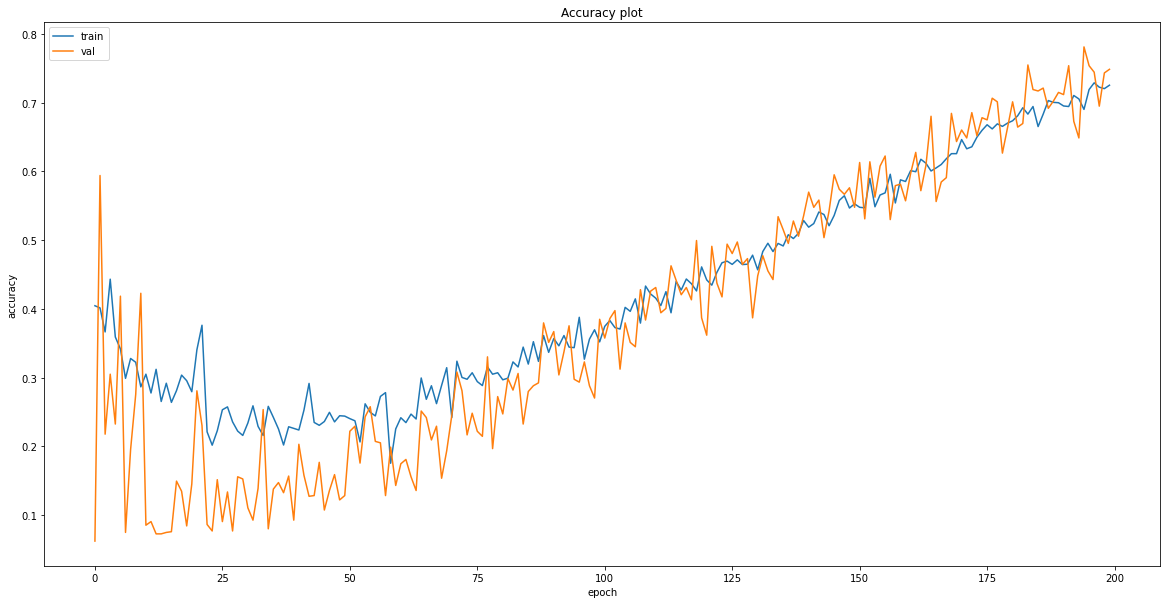

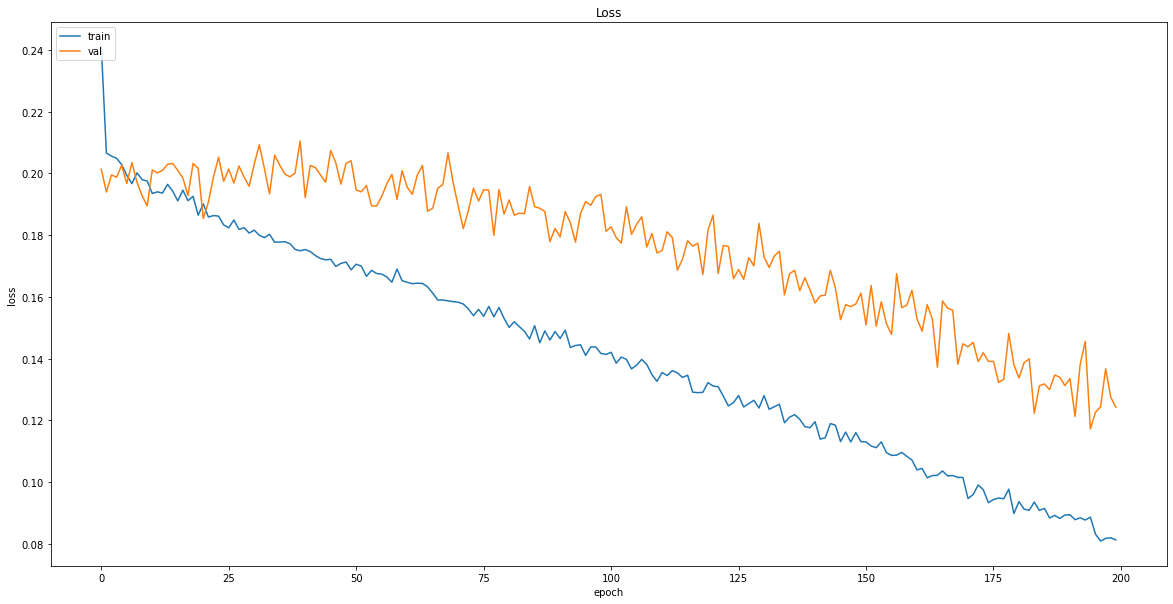

In [276]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [277]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [278]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-02-05        15.20  14.400475  -0.000000  24810300.0     2.0
2019-02-06        14.87  14.472709 -25.974048  23696400.0     2.0
2019-02-07        14.59  14.490754 -44.155838  21810900.0     2.0
2019-02-08        14.00  14.415253 -81.935503  19302900.0     1.0
2019-02-11        13.75  14.312907 -83.060094  17347800.0     2.0

In [279]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [280]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [281]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [282]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [283]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1295 - accuracy: 0.7064 - mean_squared_error: 2.4417 - weighted_accuracy: 0.7064 - weighted_mean_squared_error: 2.4417
Test loss: 0.12954705953598022
Test accuracy: 0.7064220309257507


In [284]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 1: 28, 0: 23})

In [285]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [286]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            1       2  
2019-02-15            0       2

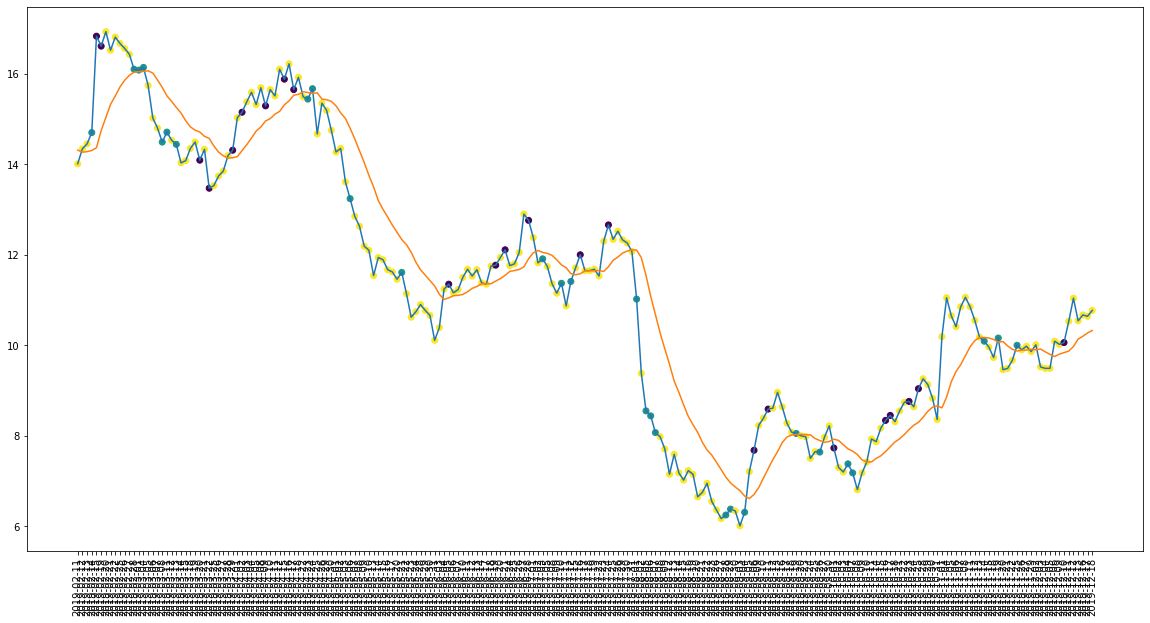

In [287]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

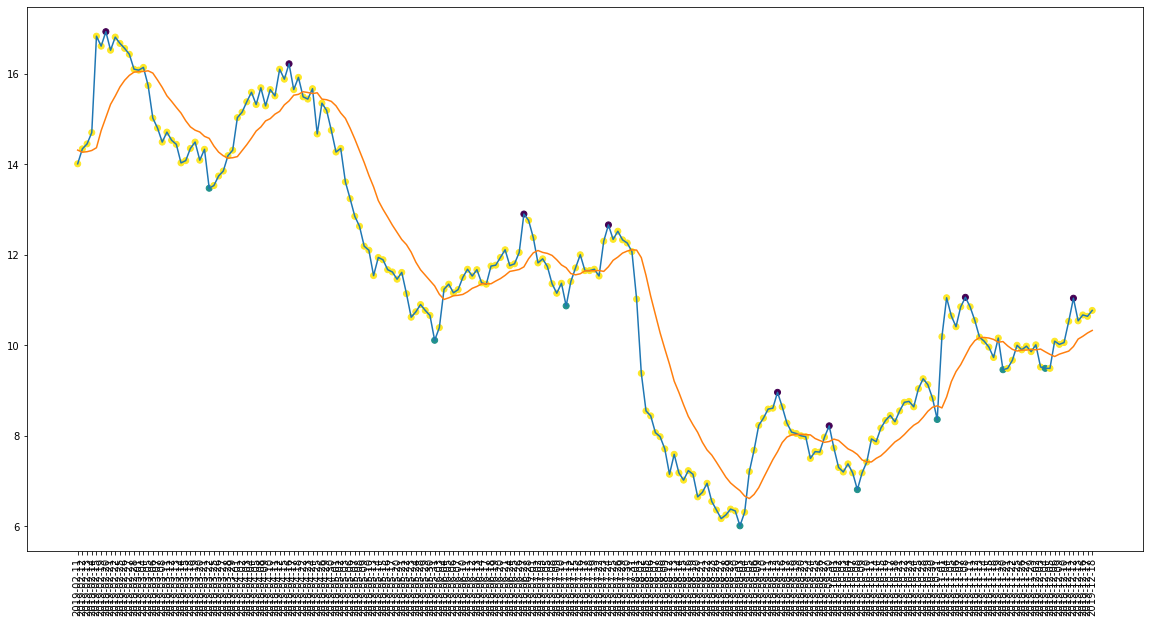

In [288]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [289]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 28
actual holds but predicted sell: 21
actual predicted holds: 153
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 75.74257425742574%
actual buys: 8
actual sells: 8
actual holds: 202


In [290]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 65.21739130434783%
Percentage holds correct: 84.33734939759036%


In [291]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.699999809265135
Shares owned at the moment: 678
Cash capital at the moment: $5.99197967386317


Price increase from previously bought: 14.175813398039839%
Share price: $16.829999923706055
Shares owned at the moment: 0
Cash capital at the moment: $11385.352393088819


Share price: $16.100000381469727
Shares owned at the moment: 705
Cash capital at the moment: $3.6382484130863304


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $10563.618545248986


Share price: $14.489999771118164
Shares owned at the moment: 727
Cash capital at the moment: $0.4195796036729007


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10172.179908507587


Share price: $15.4399995803833
Shares owned at the moment: 657
Cash capital at the moment: $0.20396495390014024


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at 

In [292]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [293]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-02-05         9.80  9.521652 -19.444449 -1562200.0     2.0
2020-02-06        10.18  9.622936 -13.194419     9300.0     2.0
2020-02-07         9.85  9.657869 -36.111087 -1326200.0     2.0
2020-02-10         9.69  9.662812 -47.222257 -2311300.0     2.0
2020-02-11         9.54  9.643918 -57.638900 -3274300.0     2.0

In [294]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [296]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [297]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [298]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 5ms/step - loss: 0.1201 - accuracy: 0.7443 - mean_squared_error: 2.3787 - weighted_accuracy: 0.7443 - weighted_mean_squared_error: 2.3787
Test loss: 0.12013589590787888
Test accuracy: 0.7442922592163086


In [299]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 1: 20, 0: 30})

In [300]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [301]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            2   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            2   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            2   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            2   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

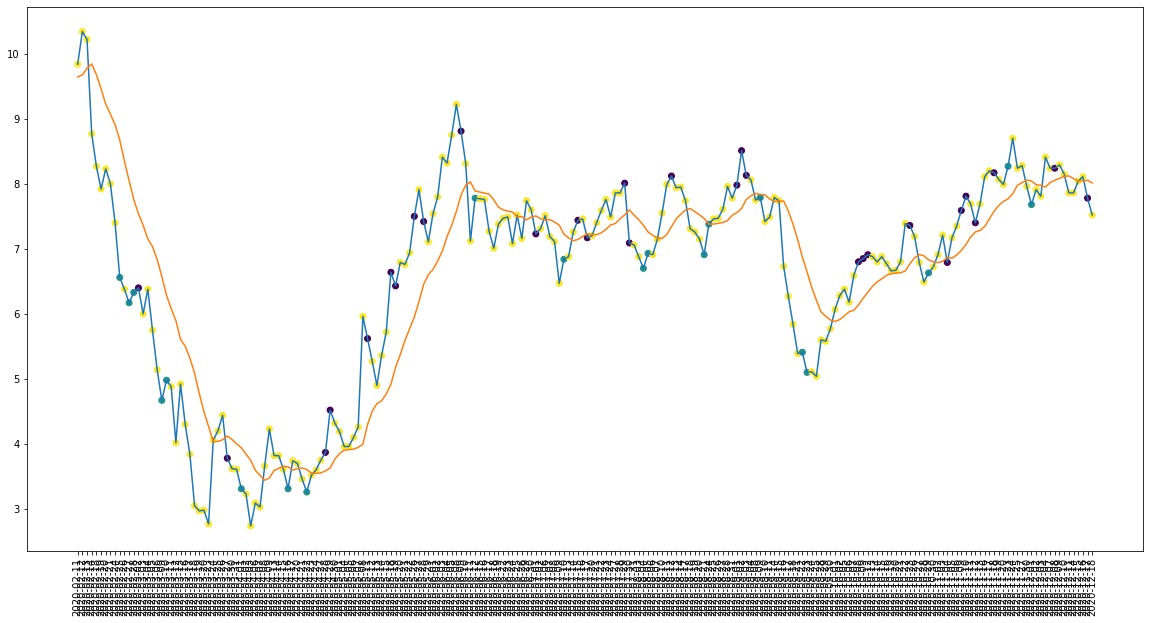

In [302]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

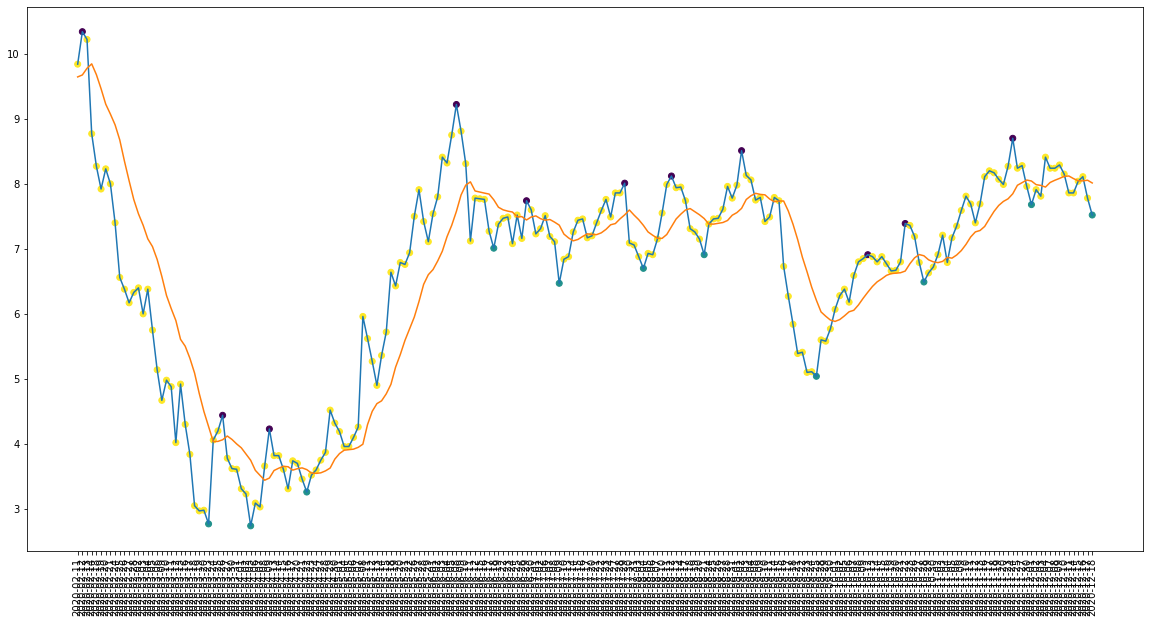

In [303]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [304]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 26
actual predicted holds: 155
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 78.68020304568527%
actual buys: 11
actual sells: 11
actual holds: 197


In [305]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 60.0%
Percentage sells correct: 70.0%
Percentage holds correct: 85.71428571428571%


In [306]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $6.559999942779541
Shares owned at the moment: 1520
Cash capital at the moment: $1.37928721427852


Stop Loss Activated!

Share price: $6.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $9672.31106068611


Share price: $6.170000076293945
Shares owned at the moment: 1563
Cash capital at the moment: $2.0807386107426282


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $9354.291238610742


Share price: $4.670000076293945
Shares owned at the moment: 1997
Cash capital at the moment: $2.6546133327447023


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $8008.517740347739


Share price: $3.309999942779541
Shares owned at the moment: 2412
Cash capital at the moment: $2.842648743029713


Stop Loss Activated!

Share price: $2.740000009536743
Shares owned at the moment: 0
Cash capital at the moment: $6593.548251682397


Share price: $3.3099999427

In [307]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
